In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
2_3_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5280 - accuracy: 0.6894 - precision: 0.9536 - recall: 0.6861 - f1: 0.7851 - specificity: 0.7467 - negative_predictive_value: 0.2454 - matthews_correlation_coefficient: 0.2901 - val_loss: 0.5368 - val_accuracy: 0.6739 - val_precision: 0.9355 - val_recall: 0.6425 - val_f1: 0.7589 - val_specificity: 0.7899 - val_negative_predictive_value: 0.2490 - val_matthews_correlation_coefficient: 0.2773

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27734, saving model to ../models/autoencoders_requirements/blurred_2020_03_26-00_24_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4809 - accuracy: 0.6725 - precision: 0.9711 - recall: 0.6531 - f1: 0.7711 - specificity: 0.7902 - negative_predictive_value: 0.2475 - matthews_correlation_coefficient: 0.3053 - val_loss: 0.4555 - val_accuracy: 0.8335 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4170 - accuracy: 0.7603 - precision: 0.9741 - recall: 0.7520 - f1: 0.8443 - specificity: 0.8352 - negative_predictive_value: 0.3068 - matthews_correlation_coefficient: 0.3976 - val_loss: 0.4851 - val_accuracy: 0.7147 - val_precision: 0.9469 - val_recall: 0.6810 - val_f1: 0.7897 - val_specificity: 0.7716 - val_negative_predictive_value: 0.2583 - val_matthews_correlation_coefficient: 0.3315

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37615
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4064 - accuracy: 0.7623 - precision: 0.9767 - recall: 0.7481 - f1: 0.8429 - specificity: 0.8252 - negative_predictive_value: 0.3057 - matthews_correlation_coefficient: 0.3962 - val_loss: 0.4871 - val_accuracy: 0.7485 - val_precision: 0.9428 - val_recall: 0.7231 - val_f1: 0.8163 - val_specificity: 0.7434 - val_negative_predictive_value: 0.2788 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39957
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3795 - accuracy: 0.7839 - precision: 0.9811 - recall: 0.7732 - f1: 0.8612 - specificity: 0.8784 - negative_predictive_value: 0.3460 - matthews_correlation_coefficient: 0.4525 - val_loss: 0.3974 - val_accuracy: 0.8127 - val_precision: 0.9340 - val_recall: 0.8042 - val_f1: 0.8621 - val_specificity: 0.6841 - val_negative_predictive_value: 0.3391 - val_matthews_correlation_coefficient: 0.3833

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.39957
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3795 - accuracy: 0.7792 - precision: 0.9796 - recall: 0.7696 - f1: 0.8587 - specificity: 0.8511 - negative_predictive_value: 0.3286 - matthews_correlation_coefficient: 0.4293 - val_loss: 0.4301 - val_accuracy: 0.7823 - val_precision: 0.9446 - val_recall: 0.7579 - val_f1: 0.8393 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3466 - accuracy: 0.8143 - precision: 0.9837 - recall: 0.8063 - f1: 0.8838 - specificity: 0.8590 - negative_predictive_value: 0.3695 - matthews_correlation_coefficient: 0.4763 - val_loss: 0.3191 - val_accuracy: 0.8716 - val_precision: 0.9247 - val_recall: 0.8793 - val_f1: 0.9003 - val_specificity: 0.6030 - val_negative_predictive_value: 0.4424 - val_matthews_correlation_coefficient: 0.4358

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44494
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3505 - accuracy: 0.8024 - precision: 0.9827 - recall: 0.7898 - f1: 0.8726 - specificity: 0.8828 - negative_predictive_value: 0.3582 - matthews_correlation_coefficient: 0.4701 - val_loss: 0.3965 - val_accuracy: 0.7997 - val_precision: 0.9444 - val_recall: 0.7783 - val_f1: 0.8519 - val_specificity: 0.7960 - val_negative_predictive_value: 0.3565 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.49045
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3399 - accuracy: 0.8154 - precision: 0.9812 - recall: 0.8059 - f1: 0.8823 - specificity: 0.8572 - negative_predictive_value: 0.3755 - matthews_correlation_coefficient: 0.4779 - val_loss: 0.4601 - val_accuracy: 0.7754 - val_precision: 0.9517 - val_recall: 0.7449 - val_f1: 0.8332 - val_specificity: 0.8472 - val_negative_predictive_value: 0.3399 - val_matthews_correlation_coefficient: 0.4076

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.49045
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3452 - accuracy: 0.8178 - precision: 0.9833 - recall: 0.8103 - f1: 0.8855 - specificity: 0.8920 - negative_predictive_value: 0.3878 - matthews_correlation_coefficient: 0.4998 - val_loss: 0.4042 - val_accuracy: 0.8205 - val_precision: 0.9437 - val_recall: 0.8036 - val_f1: 0.8654 - val_spe


Epoch 00073: val_matthews_correlation_coefficient improved from 0.49045 to 0.49061, saving model to ../models/autoencoders_requirements/blurred_2020_03_26-00_24_21.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3083 - accuracy: 0.8393 - precision: 0.9869 - recall: 0.8308 - f1: 0.9002 - specificity: 0.8872 - negative_predictive_value: 0.4074 - matthews_correlation_coefficient: 0.5248 - val_loss: 0.4053 - val_accuracy: 0.8395 - val_precision: 0.9382 - val_recall: 0.8304 - val_f1: 0.8784 - val_specificity: 0.7578 - val_negative_predictive_value: 0.4224 - val_matthews_correlation_coefficient: 0.4486

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.49061
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3179 - accuracy: 0.8297 - precision: 0.9753 - recall: 0.8175 - f1: 0.8878 - specificity: 0.8784 - negative_predictive_value: 0.3921 - matthews_correlation_coefficient: 0.4997 - val_loss: 0.4332 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3085 - accuracy: 0.8367 - precision: 0.9867 - recall: 0.8284 - f1: 0.8986 - specificity: 0.8926 - negative_predictive_value: 0.3980 - matthews_correlation_coefficient: 0.5176 - val_loss: 0.3335 - val_accuracy: 0.8560 - val_precision: 0.9298 - val_recall: 0.8562 - val_f1: 0.8900 - val_specificity: 0.6681 - val_negative_predictive_value: 0.4541 - val_matthews_correlation_coefficient: 0.4363

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.49672
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3066 - accuracy: 0.8349 - precision: 0.9876 - recall: 0.8256 - f1: 0.8969 - specificity: 0.9099 - negative_predictive_value: 0.4121 - matthews_correlation_coefficient: 0.5315 - val_loss: 0.3066 - val_accuracy: 0.8786 - val_precision: 0.9356 - val_recall: 0.8770 - val_f1: 0.9040 - val_specificity: 0.6729 - val_negative_predictive_value: 0.4699 - val_matthews_correlation_coefficie

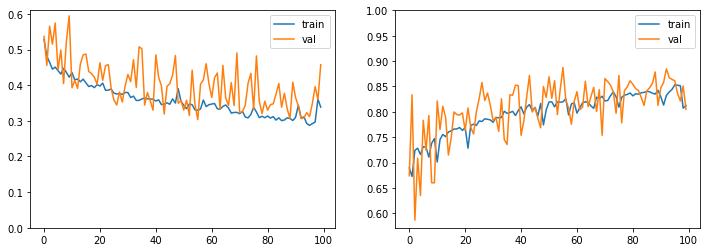

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6688 - accuracy: 0.5889 - precision: 0.7830 - recall: 0.5689 - f1: 0.6425 - specificity: 0.6217 - negative_predictive_value: 0.3948 - matthews_correlation_coefficient: 0.1846 - val_loss: 0.6671 - val_accuracy: 0.6071 - val_precision: 0.8049 - val_recall: 0.5337 - val_f1: 0.6348 - val_specificity: 0.7345 - val_negative_predictive_value: 0.4335 - val_matthews_correlation_coefficient: 0.2518

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25177, saving model to ../models/autoencoders_requirements/looking_away_2020_03_26-00_39_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6590 - accuracy: 0.6174 - precision: 0.7967 - recall: 0.6169 - f1: 0.6839 - specificity: 0.6389 - negative_predictive_value: 0.4297 - matthews_correlation_coefficient: 0.2397 - val_loss: 0.6739 - val_accuracy: 0.5820 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6237 - accuracy: 0.6573 - precision: 0.8251 - recall: 0.6475 - f1: 0.7163 - specificity: 0.6765 - negative_predictive_value: 0.4615 - matthews_correlation_coefficient: 0.3050 - val_loss: 0.5826 - val_accuracy: 0.6869 - val_precision: 0.7661 - val_recall: 0.7236 - val_f1: 0.7414 - val_specificity: 0.5566 - val_negative_predictive_value: 0.4956 - val_matthews_correlation_coefficient: 0.2700

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.31121
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6148 - accuracy: 0.6670 - precision: 0.8278 - recall: 0.6671 - f1: 0.7309 - specificity: 0.6776 - negative_predictive_value: 0.4751 - matthews_correlation_coefficient: 0.3223 - val_loss: 0.5603 - val_accuracy: 0.7077 - val_precision: 0.7852 - val_recall: 0.7349 - val_f1: 0.7560 - val_specificity: 0.6030 - val_negative_predictive_value: 0.5231 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5795 - accuracy: 0.6985 - precision: 0.8348 - recall: 0.6975 - f1: 0.7539 - specificity: 0.6993 - negative_predictive_value: 0.5121 - matthews_correlation_coefficient: 0.3714 - val_loss: 0.6223 - val_accuracy: 0.6661 - val_precision: 0.8285 - val_recall: 0.6086 - val_f1: 0.6963 - val_specificity: 0.7602 - val_negative_predictive_value: 0.4862 - val_matthews_correlation_coefficient: 0.3396

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37731
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5720 - accuracy: 0.7007 - precision: 0.8475 - recall: 0.6966 - f1: 0.7590 - specificity: 0.7177 - negative_predictive_value: 0.5141 - matthews_correlation_coefficient: 0.3859 - val_loss: 0.6076 - val_accuracy: 0.6696 - val_precision: 0.8316 - val_recall: 0.6105 - val_f1: 0.6987 - val_specificity: 0.7651 - val_negative_predictive_value: 0.4890 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38757
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5592 - accuracy: 0.7100 - precision: 0.8425 - recall: 0.7062 - f1: 0.7623 - specificity: 0.7171 - negative_predictive_value: 0.5263 - matthews_correlation_coefficient: 0.3956 - val_loss: 0.6374 - val_accuracy: 0.6297 - val_precision: 0.8594 - val_recall: 0.5198 - val_f1: 0.6430 - val_specificity: 0.8466 - val_negative_predictive_value: 0.4581 - val_matthews_correlation_coefficient: 0.3393

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38757
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5539 - accuracy: 0.7113 - precision: 0.8581 - recall: 0.7057 - f1: 0.7671 - specificity: 0.7421 - negative_predictive_value: 0.5336 - matthews_correlation_coefficient: 0.4170 - val_loss: 0.5955 - val_accuracy: 0.6557 - val_precision: 0.8469 - val_recall: 0.5749 - val_f1: 0.6793 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.38757
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5604 - accuracy: 0.7000 - precision: 0.8493 - recall: 0.6943 - f1: 0.7545 - specificity: 0.7239 - negative_predictive_value: 0.5208 - matthews_correlation_coefficient: 0.3916 - val_loss: 0.5498 - val_accuracy: 0.7095 - val_precision: 0.8031 - val_recall: 0.7082 - val_f1: 0.7490 - val_specificity: 0.6630 - val_negative_predictive_value: 0.5276 - val_matthews_correlation_coefficient: 0.3493

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38757
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5426 - accuracy: 0.7178 - precision: 0.8592 - recall: 0.7146 - f1: 0.7738 - specificity: 0.7330 - negative_predictive_value: 0.5330 - matthews_correlation_coefficient: 0.4173 - val_loss: 0.6099 - val_accuracy: 0.6644 - val_precision: 0.8490 - val_recall: 0.5870 - val_f1: 0.6884 - val_spe

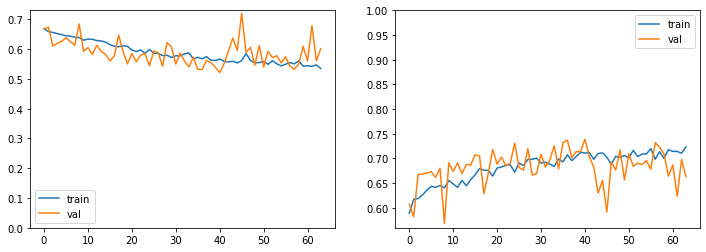

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6436 - accuracy: 0.6208 - precision: 0.6975 - recall: 0.6283 - f1: 0.6383 - specificity: 0.6062 - negative_predictive_value: 0.5477 - matthews_correlation_coefficient: 0.2422 - val_loss: 0.7109 - val_accuracy: 0.5455 - val_precision: 0.7306 - val_recall: 0.3515 - val_f1: 0.4650 - val_specificity: 0.8306 - val_negative_predictive_value: 0.4785 - val_matthews_correlation_coefficient: 0.1937

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19372, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_26-00_48_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6016 - accuracy: 0.6870 - precision: 0.7356 - recall: 0.7393 - f1: 0.7273 - specificity: 0.6147 - negative_predictive_value: 0.6305 - matthews_correlation_coefficient: 0.3606 - val_loss: 0.6493 - val_accuracy: 0.5924 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.44688 to 0.45509, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_26-00_48_25.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5046 - accuracy: 0.7601 - precision: 0.7647 - recall: 0.8722 - f1: 0.8085 - specificity: 0.5956 - negative_predictive_value: 0.7640 - matthews_correlation_coefficient: 0.4966 - val_loss: 0.5237 - val_accuracy: 0.7337 - val_precision: 0.7468 - val_recall: 0.7727 - val_f1: 0.7570 - val_specificity: 0.6498 - val_negative_predictive_value: 0.6754 - val_matthews_correlation_coefficient: 0.4220

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.45509
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4952 - accuracy: 0.7631 - precision: 0.7718 - recall: 0.8479 - f1: 0.8029 - specificity: 0.6342 - negative_predictive_value: 0.7416 - matthews_correlation_coefficient: 0.4981 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4673 - accuracy: 0.7772 - precision: 0.7951 - recall: 0.8502 - f1: 0.8173 - specificity: 0.6665 - negative_predictive_value: 0.7511 - matthews_correlation_coefficient: 0.5304 - val_loss: 0.4973 - val_accuracy: 0.7337 - val_precision: 0.7809 - val_recall: 0.7130 - val_f1: 0.7426 - val_specificity: 0.7324 - val_negative_predictive_value: 0.6547 - val_matthews_correlation_coefficient: 0.4401

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.49061
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4622 - accuracy: 0.7770 - precision: 0.7939 - recall: 0.8478 - f1: 0.8139 - specificity: 0.6752 - negative_predictive_value: 0.7541 - matthews_correlation_coefficient: 0.5358 - val_loss: 0.4764 - val_accuracy: 0.7728 - val_precision: 0.7438 - val_recall: 0.8685 - val_f1: 0.7985 - val_specificity: 0.6018 - val_negative_predictive_value: 0.7880 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.49892 to 0.49947, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_26-00_48_25.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4609 - accuracy: 0.7824 - precision: 0.7948 - recall: 0.8475 - f1: 0.8131 - specificity: 0.6771 - negative_predictive_value: 0.7668 - matthews_correlation_coefficient: 0.5416 - val_loss: 0.4913 - val_accuracy: 0.7502 - val_precision: 0.7624 - val_recall: 0.7789 - val_f1: 0.7674 - val_specificity: 0.6792 - val_negative_predictive_value: 0.6984 - val_matthews_correlation_coefficient: 0.4592

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49947
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4477 - accuracy: 0.7876 - precision: 0.8112 - recall: 0.8481 - f1: 0.8240 - specificity: 0.6991 - negative_predictive_value: 0.7603 - matthews_correlation_coefficient: 0.5584 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4326 - accuracy: 0.7976 - precision: 0.8161 - recall: 0.8588 - f1: 0.8312 - specificity: 0.7015 - negative_predictive_value: 0.7722 - matthews_correlation_coefficient: 0.5748 - val_loss: 0.5874 - val_accuracy: 0.7233 - val_precision: 0.7469 - val_recall: 0.7385 - val_f1: 0.7398 - val_specificity: 0.6691 - val_negative_predictive_value: 0.6592 - val_matthews_correlation_coefficient: 0.4064

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50911
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4366 - accuracy: 0.7976 - precision: 0.8152 - recall: 0.8447 - f1: 0.8236 - specificity: 0.7261 - negative_predictive_value: 0.7758 - matthews_correlation_coefficient: 0.5813 - val_loss: 0.4790 - val_accuracy: 0.7624 - val_precision: 0.7663 - val_recall: 0.7987 - val_f1: 0.7796 - val_specificity: 0.6735 - val_negative_predictive_value: 0.7201 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.51995
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4300 - accuracy: 0.8011 - precision: 0.8237 - recall: 0.8547 - f1: 0.8338 - specificity: 0.7213 - negative_predictive_value: 0.7683 - matthews_correlation_coefficient: 0.5832 - val_loss: 0.4722 - val_accuracy: 0.7728 - val_precision: 0.7329 - val_recall: 0.8959 - val_f1: 0.8032 - val_specificity: 0.5617 - val_negative_predictive_value: 0.8154 - val_matthews_correlation_coefficient: 0.4997

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.51995
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4272 - accuracy: 0.7980 - precision: 0.8197 - recall: 0.8537 - f1: 0.8309 - specificity: 0.7099 - negative_predictive_value: 0.7716 - matthews_correlation_coefficient: 0.5779 - val_loss: 0.5089 - val_accuracy: 0.7389 - val_precision: 0.7988 - val_recall: 0.7039 - val_f1: 0.7451 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.53948
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4168 - accuracy: 0.8126 - precision: 0.8239 - recall: 0.8611 - f1: 0.8363 - specificity: 0.7375 - negative_predictive_value: 0.7855 - matthews_correlation_coefficient: 0.6031 - val_loss: 0.4543 - val_accuracy: 0.7684 - val_precision: 0.7619 - val_recall: 0.8216 - val_f1: 0.7886 - val_specificity: 0.6560 - val_negative_predictive_value: 0.7350 - val_matthews_correlation_coefficient: 0.4866

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.53948
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4325 - accuracy: 0.7980 - precision: 0.8178 - recall: 0.8393 - f1: 0.8227 - specificity: 0.7289 - negative_predictive_value: 0.7688 - matthews_correlation_coefficient: 0.5781 - val_loss: 0.5800 - val_accuracy: 0.6982 - val_precision: 0.7723 - val_recall: 0.6405 - val_f1: 0.6969 - val_spe

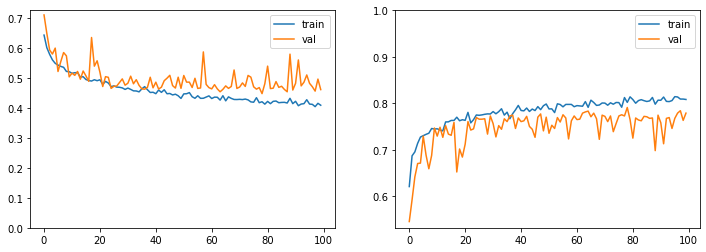

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5714 - accuracy: 0.7113 - precision: 0.9721 - recall: 0.7090 - f1: 0.7926 - specificity: 0.6789 - negative_predictive_value: 0.2281 - matthews_correlation_coefficient: 0.2835 - val_loss: 0.4741 - val_accuracy: 0.8040 - val_precision: 0.9751 - val_recall: 0.8167 - val_f1: 0.8867 - val_specificity: 0.6369 - val_negative_predictive_value: 0.2050 - val_matthews_correlation_coefficient: 0.2807

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28068, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_26-01_03_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4649 - accuracy: 0.8026 - precision: 0.9806 - recall: 0.8078 - f1: 0.8798 - specificity: 0.6773 - negative_predictive_value: 0.2508 - matthews_correlation_coefficient: 0.3292 - val_loss: 0.4157 - val_accuracy: 0.8205 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3493 - accuracy: 0.8636 - precision: 0.9875 - recall: 0.8665 - f1: 0.9211 - specificity: 0.7391 - negative_predictive_value: 0.3087 - matthews_correlation_coefficient: 0.4168 - val_loss: 0.4981 - val_accuracy: 0.8040 - val_precision: 0.9816 - val_recall: 0.8111 - val_f1: 0.8866 - val_specificity: 0.6887 - val_negative_predictive_value: 0.2111 - val_matthews_correlation_coefficient: 0.3064

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38469
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3441 - accuracy: 0.8720 - precision: 0.9871 - recall: 0.8760 - f1: 0.9265 - specificity: 0.7383 - negative_predictive_value: 0.3349 - matthews_correlation_coefficient: 0.4407 - val_loss: 0.4989 - val_accuracy: 0.8075 - val_precision: 0.9816 - val_recall: 0.8152 - val_f1: 0.8889 - val_specificity: 0.6842 - val_negative_predictive_value: 0.2233 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3095 - accuracy: 0.8883 - precision: 0.9883 - recall: 0.8916 - f1: 0.9362 - specificity: 0.7562 - negative_predictive_value: 0.3577 - matthews_correlation_coefficient: 0.4640 - val_loss: 0.5074 - val_accuracy: 0.8023 - val_precision: 0.9866 - val_recall: 0.8044 - val_f1: 0.8843 - val_specificity: 0.7450 - val_negative_predictive_value: 0.2201 - val_matthews_correlation_coefficient: 0.3333

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43754
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3144 - accuracy: 0.8757 - precision: 0.9882 - recall: 0.8756 - f1: 0.9267 - specificity: 0.7144 - negative_predictive_value: 0.3361 - matthews_correlation_coefficient: 0.4368 - val_loss: 0.3617 - val_accuracy: 0.8656 - val_precision: 0.9846 - val_recall: 0.8735 - val_f1: 0.9248 - val_specificity: 0.7068 - val_negative_predictive_value: 0.2887 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2914 - accuracy: 0.9000 - precision: 0.9889 - recall: 0.9011 - f1: 0.9410 - specificity: 0.7371 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.4901 - val_loss: 0.5244 - val_accuracy: 0.7875 - val_precision: 0.9882 - val_recall: 0.7876 - val_f1: 0.8746 - val_specificity: 0.7405 - val_negative_predictive_value: 0.2181 - val_matthews_correlation_coefficient: 0.3272

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43754
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2876 - accuracy: 0.8985 - precision: 0.9887 - recall: 0.9030 - f1: 0.9426 - specificity: 0.7403 - negative_predictive_value: 0.3945 - matthews_correlation_coefficient: 0.4862 - val_loss: 0.2540 - val_accuracy: 0.9176 - val_precision: 0.9817 - val_recall: 0.9314 - val_f1: 0.9553 - val_specificity: 0.6617 - val_negative_predictive_value: 0.3976 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.49434
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2657 - accuracy: 0.8998 - precision: 0.9902 - recall: 0.9030 - f1: 0.9436 - specificity: 0.7341 - negative_predictive_value: 0.3850 - matthews_correlation_coefficient: 0.4821 - val_loss: 0.5324 - val_accuracy: 0.7953 - val_precision: 0.9864 - val_recall: 0.7975 - val_f1: 0.8801 - val_specificity: 0.7369 - val_negative_predictive_value: 0.2171 - val_matthews_correlation_coefficient: 0.3274

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.49434
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2766 - accuracy: 0.8946 - precision: 0.9887 - recall: 0.8986 - f1: 0.9399 - specificity: 0.8028 - negative_predictive_value: 0.4150 - matthews_correlation_coefficient: 0.5171 - val_loss: 0.3876 - val_accuracy: 0.8361 - val_precision: 0.9870 - val_recall: 0.8398 - val_f1: 0.9061 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.49434
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2510 - accuracy: 0.9039 - precision: 0.9898 - recall: 0.9074 - f1: 0.9454 - specificity: 0.8017 - negative_predictive_value: 0.4332 - matthews_correlation_coefficient: 0.5357 - val_loss: 0.4782 - val_accuracy: 0.8222 - val_precision: 0.9848 - val_recall: 0.8275 - val_f1: 0.8977 - val_specificity: 0.6964 - val_negative_predictive_value: 0.2386 - val_matthews_correlation_coefficient: 0.3386

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.49434
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2409 - accuracy: 0.9063 - precision: 0.9909 - recall: 0.9089 - f1: 0.9470 - specificity: 0.7780 - negative_predictive_value: 0.4217 - matthews_correlation_coefficient: 0.5202 - val_loss: 0.3945 - val_accuracy: 0.8395 - val_precision: 0.9872 - val_recall: 0.8435 - val_f1: 0.9082 - val_spe

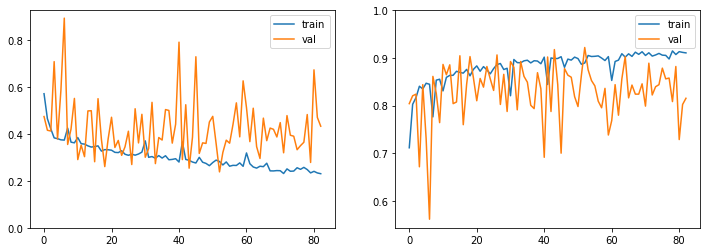

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5534 - accuracy: 0.7069 - precision: 0.9967 - recall: 0.7089 - f1: 0.8172 - specificity: 0.2184 - negative_predictive_value: 0.0326 - matthews_correlation_coefficient: 0.0618 - val_loss: 0.4992 - val_accuracy: 0.6765 - val_precision: 1.0000 - val_recall: 0.6815 - val_f1: 0.8058 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0305 - val_matthews_correlation_coefficient: 0.0733

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07326, saving model to ../models/autoencoders_requirements/washed_out_2020_03_26-01_15_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4329 - accuracy: 0.7440 - precision: 0.9984 - recall: 0.7409 - f1: 0.8457 - specificity: 0.2483 - negative_predictive_value: 0.0322 - matthews_correlation_coefficient: 0.0717 - val_loss: 0.5733 - val_accuracy: 0.6800 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.10218
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2688 - accuracy: 0.8386 - precision: 0.9987 - recall: 0.8355 - f1: 0.9050 - specificity: 0.2690 - negative_predictive_value: 0.0638 - matthews_correlation_coefficient: 0.1102 - val_loss: 0.2610 - val_accuracy: 0.8231 - val_precision: 1.0000 - val_recall: 0.8256 - val_f1: 0.9018 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0533 - val_matthews_correlation_coefficient: 0.1067

Epoch 00015: val_matthews_correlation_coefficient improved from 0.10218 to 0.10674, saving model to ../models/autoencoders_requirements/washed_out_2020_03_26-01_15_10.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2725 - accuracy: 0.8354 - precision: 0.9986 - recall: 0.8361 - f1: 0.9061 - specificity: 0.2655 - negative_predictive_value: 0.0672 - matthews_correlation_coefficient: 0.1142 - val_loss: 0.4084 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2288 - accuracy: 0.8482 - precision: 0.9990 - recall: 0.8485 - f1: 0.9150 - specificity: 0.2690 - negative_predictive_value: 0.0715 - matthews_correlation_coefficient: 0.1210 - val_loss: 0.2825 - val_accuracy: 0.8239 - val_precision: 1.0000 - val_recall: 0.8266 - val_f1: 0.9025 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0540 - val_matthews_correlation_coefficient: 0.1072

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.12112
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3696 - accuracy: 0.8560 - precision: 0.9988 - recall: 0.8560 - f1: 0.9162 - specificity: 0.2724 - negative_predictive_value: 0.0713 - matthews_correlation_coefficient: 0.1185 - val_loss: 0.1797 - val_accuracy: 0.9011 - val_precision: 0.9991 - val_recall: 0.9033 - val_f1: 0.9474 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0877 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1651 - accuracy: 0.9124 - precision: 0.9993 - recall: 0.9127 - f1: 0.9529 - specificity: 0.2552 - negative_predictive_value: 0.1117 - matthews_correlation_coefficient: 0.1543 - val_loss: 0.2422 - val_accuracy: 0.8621 - val_precision: 0.9990 - val_recall: 0.8649 - val_f1: 0.9255 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0609 - val_matthews_correlation_coefficient: 0.1082

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.16915
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2102 - accuracy: 0.8790 - precision: 0.9996 - recall: 0.8790 - f1: 0.9329 - specificity: 0.2828 - negative_predictive_value: 0.1019 - matthews_correlation_coefficient: 0.1527 - val_loss: 0.2544 - val_accuracy: 0.8829 - val_precision: 0.9991 - val_recall: 0.8854 - val_f1: 0.9375 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0843 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient improved from 0.17213 to 0.18259, saving model to ../models/autoencoders_requirements/washed_out_2020_03_26-01_15_10.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1784 - accuracy: 0.9208 - precision: 0.9993 - recall: 0.9212 - f1: 0.9575 - specificity: 0.2690 - negative_predictive_value: 0.1184 - matthews_correlation_coefficient: 0.1643 - val_loss: 0.3631 - val_accuracy: 0.8274 - val_precision: 1.0000 - val_recall: 0.8301 - val_f1: 0.9049 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0560 - val_matthews_correlation_coefficient: 0.1105

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.18259
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2074 - accuracy: 0.8952 - precision: 0.9988 - recall: 0.8959 - f1: 0.9426 - specificity: 0.2517 - negative_predictive_value: 0.0858 - matthews_correlation_coefficient: 0.1344 - val_loss: 0.1123 - v


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.18259
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1744 - accuracy: 0.9258 - precision: 0.9991 - recall: 0.9265 - f1: 0.9605 - specificity: 0.2747 - negative_predictive_value: 0.1244 - matthews_correlation_coefficient: 0.1700 - val_loss: 0.7720 - val_accuracy: 0.7233 - val_precision: 1.0000 - val_recall: 0.7276 - val_f1: 0.8387 - val_specificity: 0.2703 - val_negative_predictive_value: 0.0350 - val_matthews_correlation_coefficient: 0.0809

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.18259
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2337 - accuracy: 0.8735 - precision: 0.9993 - recall: 0.8738 - f1: 0.9293 - specificity: 0.2724 - negative_predictive_value: 0.1007 - matthews_correlation_coefficient: 0.1471 - val_loss: 0.1838 - val_accuracy: 0.9037 - val_precision: 1.0000 - val_recall: 0.9052 - val_f1: 0.9493 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.18259
Epoch 00087: early stopping

   Final Accuracy:  96.18%
  Final Precision:  99.91%
     Final Recall:  96.23%
  Final F-measure:  98.04%
Final Specificity:  91.67%
        Final NPV:  20.37%
        Final MCC:  42.22%
[[  11    1]
 [  43 1098]]
              precision    recall  f1-score   support

           0       0.20      0.92      0.33        12
           1       1.00      0.96      0.98      1141

    accuracy                           0.96      1153
   macro avg       0.60      0.94      0.66      1153
weighted avg       0.99      0.96      0.97      1153



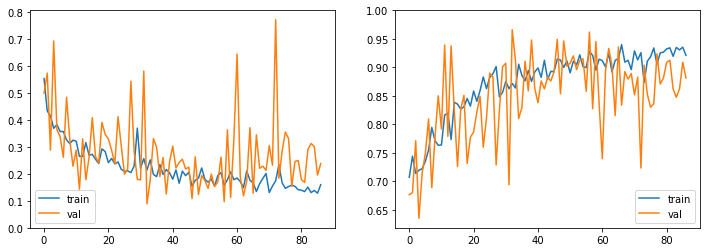

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6665 - accuracy: 0.5599 - precision: 0.9636 - recall: 0.5511 - f1: 0.6887 - specificity: 0.6060 - negative_predictive_value: 0.1036 - matthews_correlation_coefficient: 0.1191 - val_loss: 0.6407 - val_accuracy: 0.5915 - val_precision: 0.9764 - val_recall: 0.5864 - val_f1: 0.7276 - val_specificity: 0.6896 - val_negative_predictive_value: 0.1185 - val_matthews_correlation_coefficient: 0.1686

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.16861, saving model to ../models/autoencoders_requirements/pixelation_2020_03_26-01_28_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6383 - accuracy: 0.6052 - precision: 0.9676 - recall: 0.6001 - f1: 0.7309 - specificity: 0.6155 - negative_predictive_value: 0.1166 - matthews_correlation_coefficient: 0.1455 - val_loss: 0.5232 - val_accuracy: 0.7225 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.20237
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5269 - accuracy: 0.7017 - precision: 0.9776 - recall: 0.6982 - f1: 0.8104 - specificity: 0.7067 - negative_predictive_value: 0.1615 - matthews_correlation_coefficient: 0.2383 - val_loss: 0.3560 - val_accuracy: 0.7832 - val_precision: 0.9652 - val_recall: 0.8006 - val_f1: 0.8721 - val_specificity: 0.4964 - val_negative_predictive_value: 0.1654 - val_matthews_correlation_coefficient: 0.1975

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.20237
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5284 - accuracy: 0.6924 - precision: 0.9776 - recall: 0.6887 - f1: 0.8023 - specificity: 0.6954 - negative_predictive_value: 0.1553 - matthews_correlation_coefficient: 0.2280 - val_loss: 0.3056 - val_accuracy: 0.8690 - val_precision: 0.9540 - val_recall: 0.9053 - val_f1: 0.9282 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5303 - accuracy: 0.6987 - precision: 0.9772 - recall: 0.6934 - f1: 0.8066 - specificity: 0.6707 - negative_predictive_value: 0.1603 - matthews_correlation_coefficient: 0.2329 - val_loss: 0.3411 - val_accuracy: 0.8343 - val_precision: 0.9616 - val_recall: 0.8597 - val_f1: 0.9066 - val_specificity: 0.4131 - val_negative_predictive_value: 0.2112 - val_matthews_correlation_coefficient: 0.2149

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.23455
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5154 - accuracy: 0.7447 - precision: 0.9762 - recall: 0.7473 - f1: 0.8424 - specificity: 0.6754 - negative_predictive_value: 0.1834 - matthews_correlation_coefficient: 0.2569 - val_loss: 0.4144 - val_accuracy: 0.8005 - val_precision: 0.9693 - val_recall: 0.8159 - val_f1: 0.8840 - val_specificity: 0.5189 - val_negative_predictive_value: 0.1791 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4915 - accuracy: 0.7145 - precision: 0.9790 - recall: 0.7112 - f1: 0.8201 - specificity: 0.6737 - negative_predictive_value: 0.1664 - matthews_correlation_coefficient: 0.2419 - val_loss: 0.2619 - val_accuracy: 0.9237 - val_precision: 0.9482 - val_recall: 0.9726 - val_f1: 0.9598 - val_specificity: 0.2167 - val_negative_predictive_value: 0.3486 - val_matthews_correlation_coefficient: 0.2344

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.23455
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4917 - accuracy: 0.7291 - precision: 0.9799 - recall: 0.7268 - f1: 0.8312 - specificity: 0.7314 - negative_predictive_value: 0.1747 - matthews_correlation_coefficient: 0.2661 - val_loss: 0.3064 - val_accuracy: 0.8820 - val_precision: 0.9500 - val_recall: 0.9249 - val_f1: 0.9365 - val_specificity: 0.2595 - val_negative_predictive_value: 0.2471 - val_matthews_correlation_coefficie

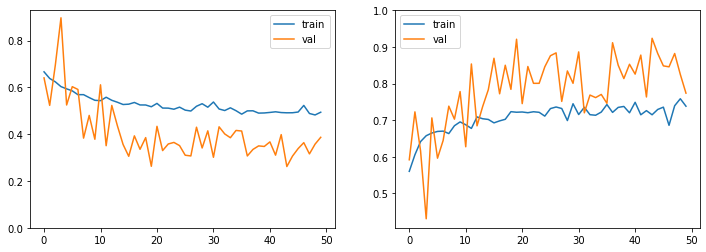

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.6640 - precision: 0.9757 - recall: 0.6445 - f1: 0.7696 - specificity: 0.8361 - negative_predictive_value: 0.2282 - matthews_correlation_coefficient: 0.3073 - val_loss: 0.5808 - val_accuracy: 0.6357 - val_precision: 0.9594 - val_recall: 0.5850 - val_f1: 0.7227 - val_specificity: 0.9053 - val_negative_predictive_value: 0.2160 - val_matthews_correlation_coefficient: 0.3182

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31825, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_26-01_35_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5005 - accuracy: 0.6646 - precision: 0.9838 - recall: 0.6360 - f1: 0.7681 - specificity: 0.8631 - negative_predictive_value: 0.2293 - matthews_correlation_coefficient: 0.3247 - val_loss: 0.4941 - val_accuracy: 0.6557 - val_preci


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.43875
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3918 - accuracy: 0.8178 - precision: 0.9810 - recall: 0.8113 - f1: 0.8842 - specificity: 0.8418 - negative_predictive_value: 0.3726 - matthews_correlation_coefficient: 0.4706 - val_loss: 0.4655 - val_accuracy: 0.7823 - val_precision: 0.9591 - val_recall: 0.7479 - val_f1: 0.8388 - val_specificity: 0.8758 - val_negative_predictive_value: 0.3104 - val_matthews_correlation_coefficient: 0.4297

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.43875
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3836 - accuracy: 0.8232 - precision: 0.9832 - recall: 0.8146 - f1: 0.8881 - specificity: 0.8710 - negative_predictive_value: 0.3771 - matthews_correlation_coefficient: 0.4862 - val_loss: 0.3882 - val_accuracy: 0.8456 - val_precision: 0.9461 - val_recall: 0.8297 - val_f1: 0.8826 - val_spe


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.47663
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3453 - accuracy: 0.8510 - precision: 0.9850 - recall: 0.8472 - f1: 0.9088 - specificity: 0.8578 - negative_predictive_value: 0.4139 - matthews_correlation_coefficient: 0.5222 - val_loss: 0.3755 - val_accuracy: 0.8569 - val_precision: 0.9461 - val_recall: 0.8417 - val_f1: 0.8896 - val_specificity: 0.7694 - val_negative_predictive_value: 0.3951 - val_matthews_correlation_coefficient: 0.4751

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.47663
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3528 - accuracy: 0.8479 - precision: 0.9836 - recall: 0.8458 - f1: 0.9069 - specificity: 0.8527 - negative_predictive_value: 0.4159 - matthews_correlation_coefficient: 0.5193 - val_loss: 0.5639 - val_accuracy: 0.7693 - val_precision: 0.9601 - val_recall: 0.7326 - val_f1: 0.8294 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3544 - accuracy: 0.8362 - precision: 0.9830 - recall: 0.8327 - f1: 0.8987 - specificity: 0.8400 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.5036 - val_loss: 0.4132 - val_accuracy: 0.8283 - val_precision: 0.9581 - val_recall: 0.7996 - val_f1: 0.8703 - val_specificity: 0.8398 - val_negative_predictive_value: 0.3589 - val_matthews_correlation_coefficient: 0.4706

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.48774
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3531 - accuracy: 0.8516 - precision: 0.9827 - recall: 0.8503 - f1: 0.9092 - specificity: 0.8544 - negative_predictive_value: 0.4204 - matthews_correlation_coefficient: 0.5222 - val_loss: 0.3262 - val_accuracy: 0.8690 - val_precision: 0.9506 - val_recall: 0.8509 - val_f1: 0.8968 - val_specificity: 0.7935 - val_negative_predictive_value: 0.4195 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3283 - accuracy: 0.8623 - precision: 0.9868 - recall: 0.8590 - f1: 0.9163 - specificity: 0.8833 - negative_predictive_value: 0.4487 - matthews_correlation_coefficient: 0.5565 - val_loss: 0.2803 - val_accuracy: 0.8777 - val_precision: 0.9312 - val_recall: 0.8804 - val_f1: 0.9040 - val_specificity: 0.6374 - val_negative_predictive_value: 0.4202 - val_matthews_correlation_coefficient: 0.4454

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.52580
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3330 - accuracy: 0.8521 - precision: 0.9867 - recall: 0.8485 - f1: 0.9102 - specificity: 0.8622 - negative_predictive_value: 0.4283 - matthews_correlation_coefficient: 0.5336 - val_loss: 0.4277 - val_accuracy: 0.8456 - val_precision: 0.9624 - val_recall: 0.8143 - val_f1: 0.8809 - val_specificity: 0.8902 - val_negative_predictive_value: 0.3874 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3005 - accuracy: 0.8709 - precision: 0.9868 - recall: 0.8686 - f1: 0.9225 - specificity: 0.8597 - negative_predictive_value: 0.4554 - matthews_correlation_coefficient: 0.5602 - val_loss: 0.2870 - val_accuracy: 0.8794 - val_precision: 0.9383 - val_recall: 0.8757 - val_f1: 0.9046 - val_specificity: 0.6779 - val_negative_predictive_value: 0.4195 - val_matthews_correlation_coefficient: 0.4651

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.52580
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3084 - accuracy: 0.8703 - precision: 0.9866 - recall: 0.8679 - f1: 0.9218 - specificity: 0.8597 - negative_predictive_value: 0.4508 - matthews_correlation_coefficient: 0.5547 - val_loss: 0.3268 - val_accuracy: 0.8690 - val_precision: 0.9496 - val_recall: 0.8520 - val_f1: 0.8972 - val_specificity: 0.7869 - val_negative_predictive_value: 0.4160 - val_matthews_correlation_coefficie


Epoch 00086: val_matthews_correlation_coefficient improved from 0.53399 to 0.54794, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_26-01_35_24.h5
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2894 - accuracy: 0.8772 - precision: 0.9884 - recall: 0.8745 - f1: 0.9262 - specificity: 0.8866 - negative_predictive_value: 0.4705 - matthews_correlation_coefficient: 0.5823 - val_loss: 0.2879 - val_accuracy: 0.8812 - val_precision: 0.9460 - val_recall: 0.8693 - val_f1: 0.9049 - val_specificity: 0.7617 - val_negative_predictive_value: 0.4522 - val_matthews_correlation_coefficient: 0.5180

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.54794
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3113 - accuracy: 0.8707 - precision: 0.9890 - recall: 0.8665 - f1: 0.9218 - specificity: 0.9050 - negative_predictive_value: 0.4600 - matthews_correlation_coefficient: 0.5770 - val_loss: 0.31

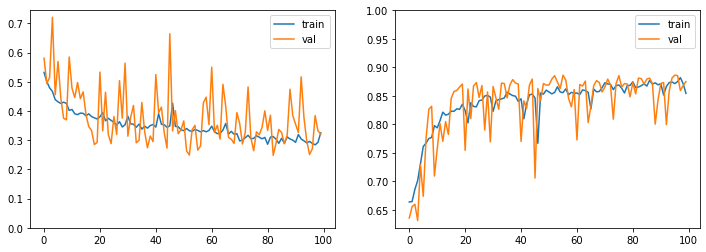

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6338 - accuracy: 0.5440 - precision: 0.9084 - recall: 0.4799 - f1: 0.6123 - specificity: 0.7897 - negative_predictive_value: 0.2698 - matthews_correlation_coefficient: 0.2214 - val_loss: 0.5844 - val_accuracy: 0.5447 - val_precision: 0.8764 - val_recall: 0.4685 - val_f1: 0.6041 - val_specificity: 0.7886 - val_negative_predictive_value: 0.2817 - val_matthews_correlation_coefficient: 0.2287

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22869, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_26-01_50_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6317 - accuracy: 0.5488 - precision: 0.9151 - recall: 0.4811 - f1: 0.6189 - specificity: 0.8115 - negative_predictive_value: 0.2891 - matthews_correlation_coefficient: 0.2428 - val_loss: 0.7530 - val_accuracy: 0.4623 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5857 - accuracy: 0.6351 - precision: 0.9192 - recall: 0.5976 - f1: 0.7135 - specificity: 0.7800 - negative_predictive_value: 0.3364 - matthews_correlation_coefficient: 0.3086 - val_loss: 0.5012 - val_accuracy: 0.7303 - val_precision: 0.8358 - val_recall: 0.7712 - val_f1: 0.7996 - val_specificity: 0.4996 - val_negative_predictive_value: 0.3784 - val_matthews_correlation_coefficient: 0.2660

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.32304
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5817 - accuracy: 0.6447 - precision: 0.9204 - recall: 0.6099 - f1: 0.7236 - specificity: 0.7791 - negative_predictive_value: 0.3476 - matthews_correlation_coefficient: 0.3208 - val_loss: 0.5320 - val_accuracy: 0.6886 - val_precision: 0.8833 - val_recall: 0.6613 - val_f1: 0.7528 - val_specificity: 0.7281 - val_negative_predictive_value: 0.3651 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5619 - accuracy: 0.6612 - precision: 0.9267 - recall: 0.6313 - f1: 0.7418 - specificity: 0.7973 - negative_predictive_value: 0.3616 - matthews_correlation_coefficient: 0.3485 - val_loss: 0.5370 - val_accuracy: 0.6748 - val_precision: 0.8921 - val_recall: 0.6349 - val_f1: 0.7379 - val_specificity: 0.7609 - val_negative_predictive_value: 0.3579 - val_matthews_correlation_coefficient: 0.3407

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.35829
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5426 - accuracy: 0.6939 - precision: 0.9253 - recall: 0.6735 - f1: 0.7732 - specificity: 0.7719 - negative_predictive_value: 0.3768 - matthews_correlation_coefficient: 0.3628 - val_loss: 0.5669 - val_accuracy: 0.6730 - val_precision: 0.9038 - val_recall: 0.6234 - val_f1: 0.7343 - val_specificity: 0.8022 - val_negative_predictive_value: 0.3603 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5509 - accuracy: 0.6839 - precision: 0.9249 - recall: 0.6569 - f1: 0.7553 - specificity: 0.7906 - negative_predictive_value: 0.3830 - matthews_correlation_coefficient: 0.3662 - val_loss: 0.7024 - val_accuracy: 0.6123 - val_precision: 0.9163 - val_recall: 0.5328 - val_f1: 0.6697 - val_specificity: 0.8550 - val_negative_predictive_value: 0.3253 - val_matthews_correlation_coefficient: 0.3324

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.38559
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5260 - accuracy: 0.6950 - precision: 0.9245 - recall: 0.6769 - f1: 0.7750 - specificity: 0.7796 - negative_predictive_value: 0.3897 - matthews_correlation_coefficient: 0.3752 - val_loss: 0.5587 - val_accuracy: 0.6765 - val_precision: 0.9147 - val_recall: 0.6200 - val_f1: 0.7339 - val_specificity: 0.8293 - val_negative_predictive_value: 0.3708 - val_matthews_correlation_coefficie


Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.41823
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5060 - accuracy: 0.7115 - precision: 0.9272 - recall: 0.6955 - f1: 0.7885 - specificity: 0.7832 - negative_predictive_value: 0.4084 - matthews_correlation_coefficient: 0.3975 - val_loss: 0.6407 - val_accuracy: 0.6557 - val_precision: 0.9212 - val_recall: 0.5866 - val_f1: 0.7131 - val_specificity: 0.8550 - val_negative_predictive_value: 0.3546 - val_matthews_correlation_coefficient: 0.3750

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41823
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5126 - accuracy: 0.7063 - precision: 0.9308 - recall: 0.6840 - f1: 0.7809 - specificity: 0.7855 - negative_predictive_value: 0.4013 - matthews_correlation_coefficient: 0.3919 - val_loss: 0.4604 - val_accuracy: 0.7520 - val_precision: 0.8907 - val_recall: 0.7400 - val_f1: 0.8051 - val_spe


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.42255
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5026 - accuracy: 0.7048 - precision: 0.9286 - recall: 0.6741 - f1: 0.7743 - specificity: 0.8032 - negative_predictive_value: 0.3998 - matthews_correlation_coefficient: 0.3993 - val_loss: 0.5407 - val_accuracy: 0.7025 - val_precision: 0.9134 - val_recall: 0.6535 - val_f1: 0.7573 - val_specificity: 0.8128 - val_negative_predictive_value: 0.3932 - val_matthews_correlation_coefficient: 0.4042

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.42255
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5056 - accuracy: 0.7119 - precision: 0.9284 - recall: 0.6921 - f1: 0.7870 - specificity: 0.7943 - negative_predictive_value: 0.4010 - matthews_correlation_coefficient: 0.3963 - val_loss: 0.5496 - val_accuracy: 0.6869 - val_precision: 0.9174 - val_recall: 0.6281 - val_f1: 0.7422 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.43405
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4903 - accuracy: 0.7278 - precision: 0.9323 - recall: 0.7104 - f1: 0.7993 - specificity: 0.8021 - negative_predictive_value: 0.4231 - matthews_correlation_coefficient: 0.4253 - val_loss: 0.4914 - val_accuracy: 0.7398 - val_precision: 0.9037 - val_recall: 0.7098 - val_f1: 0.7916 - val_specificity: 0.7723 - val_negative_predictive_value: 0.4278 - val_matthews_correlation_coefficient: 0.4253

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.43405
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4990 - accuracy: 0.7215 - precision: 0.9306 - recall: 0.7075 - f1: 0.7978 - specificity: 0.7805 - negative_predictive_value: 0.4157 - matthews_correlation_coefficient: 0.4074 - val_loss: 0.6554 - val_accuracy: 0.6618 - val_precision: 0.9051 - val_recall: 0.6052 - val_f1: 0.7200 - val_spe

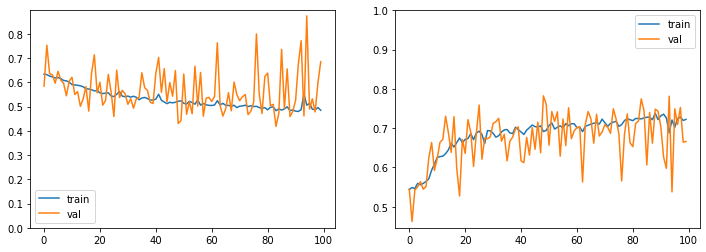

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4926 - accuracy: 0.7482 - precision: 0.8087 - recall: 0.7474 - f1: 0.7604 - specificity: 0.7461 - negative_predictive_value: 0.6919 - matthews_correlation_coefficient: 0.5035 - val_loss: 0.4088 - val_accuracy: 0.7910 - val_precision: 0.7544 - val_recall: 0.8652 - val_f1: 0.8004 - val_specificity: 0.6642 - val_negative_predictive_value: 0.8247 - val_matthews_correlation_coefficient: 0.5527

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.55273, saving model to ../models/autoencoders_requirements/varied_background_2020_03_26-02_04_45.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4302 - accuracy: 0.7764 - precision: 0.8336 - recall: 0.7712 - f1: 0.7863 - specificity: 0.7806 - negative_predictive_value: 0.7452 - matthews_correlation_coefficient: 0.5655 - val_loss: 0.3868 - val_accuracy: 0.8187 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3423 - accuracy: 0.8358 - precision: 0.8855 - recall: 0.8304 - f1: 0.8493 - specificity: 0.8563 - negative_predictive_value: 0.7923 - matthews_correlation_coefficient: 0.6819 - val_loss: 0.3338 - val_accuracy: 0.8222 - val_precision: 0.8363 - val_recall: 0.7912 - val_f1: 0.8079 - val_specificity: 0.8314 - val_negative_predictive_value: 0.7769 - val_matthews_correlation_coefficient: 0.6174

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.64319
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3411 - accuracy: 0.8282 - precision: 0.8753 - recall: 0.8275 - f1: 0.8436 - specificity: 0.8415 - negative_predictive_value: 0.7883 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.3344 - val_accuracy: 0.8317 - val_precision: 0.8633 - val_recall: 0.7820 - val_f1: 0.8148 - val_specificity: 0.8733 - val_negative_predictive_value: 0.7728 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3130 - accuracy: 0.8503 - precision: 0.8939 - recall: 0.8469 - f1: 0.8642 - specificity: 0.8674 - negative_predictive_value: 0.8064 - matthews_correlation_coefficient: 0.7069 - val_loss: 0.3183 - val_accuracy: 0.8395 - val_precision: 0.8862 - val_recall: 0.7739 - val_f1: 0.8201 - val_specificity: 0.8966 - val_negative_predictive_value: 0.7693 - val_matthews_correlation_coefficient: 0.6619

Epoch 00029: val_matthews_correlation_coefficient improved from 0.65043 to 0.66190, saving model to ../models/autoencoders_requirements/varied_background_2020_03_26-02_04_45.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3179 - accuracy: 0.8397 - precision: 0.8914 - recall: 0.8302 - f1: 0.8533 - specificity: 0.8689 - negative_predictive_value: 0.7900 - matthews_correlation_coefficient: 0.6897 - val_loss: 0.3077 - val_accuracy: 0.8465 - val_precision: 0.8276 - val_recall: 0.8562 - val_f1: 0.8377 - va

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2945 - accuracy: 0.8584 - precision: 0.8987 - recall: 0.8547 - f1: 0.8718 - specificity: 0.8658 - negative_predictive_value: 0.8087 - matthews_correlation_coefficient: 0.7134 - val_loss: 0.2987 - val_accuracy: 0.8569 - val_precision: 0.8308 - val_recall: 0.8738 - val_f1: 0.8479 - val_specificity: 0.8043 - val_negative_predictive_value: 0.8595 - val_matthews_correlation_coefficient: 0.6839

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.69346
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2896 - accuracy: 0.8579 - precision: 0.8901 - recall: 0.8489 - f1: 0.8648 - specificity: 0.8649 - negative_predictive_value: 0.8141 - matthews_correlation_coefficient: 0.7101 - val_loss: 0.2885 - val_accuracy: 0.8491 - val_precision: 0.8526 - val_recall: 0.8263 - val_f1: 0.8351 - val_specificity: 0.8489 - val_negative_predictive_value: 0.8118 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.69477
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2809 - accuracy: 0.8664 - precision: 0.9005 - recall: 0.8695 - f1: 0.8803 - specificity: 0.8688 - negative_predictive_value: 0.8334 - matthews_correlation_coefficient: 0.7357 - val_loss: 0.3189 - val_accuracy: 0.8482 - val_precision: 0.7994 - val_recall: 0.9065 - val_f1: 0.8464 - val_specificity: 0.7347 - val_negative_predictive_value: 0.8902 - val_matthews_correlation_coefficient: 0.6644

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.69477
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2797 - accuracy: 0.8638 - precision: 0.9011 - recall: 0.8616 - f1: 0.8763 - specificity: 0.8695 - negative_predictive_value: 0.8164 - matthews_correlation_coefficient: 0.7239 - val_loss: 0.2955 - val_accuracy: 0.8526 - val_precision: 0.8077 - val_recall: 0.8990 - val_f1: 0.8478 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2713 - accuracy: 0.8727 - precision: 0.9043 - recall: 0.8728 - f1: 0.8829 - specificity: 0.8715 - negative_predictive_value: 0.8332 - matthews_correlation_coefficient: 0.7422 - val_loss: 0.2683 - val_accuracy: 0.8656 - val_precision: 0.8432 - val_recall: 0.8720 - val_f1: 0.8540 - val_specificity: 0.8287 - val_negative_predictive_value: 0.8586 - val_matthews_correlation_coefficient: 0.7010

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.70967
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2679 - accuracy: 0.8722 - precision: 0.9034 - recall: 0.8629 - f1: 0.8787 - specificity: 0.8788 - negative_predictive_value: 0.8220 - matthews_correlation_coefficient: 0.7331 - val_loss: 0.2739 - val_accuracy: 0.8612 - val_precision: 0.8324 - val_recall: 0.8816 - val_f1: 0.8526 - val_specificity: 0.8063 - val_negative_predictive_value: 0.8658 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2556 - accuracy: 0.8764 - precision: 0.9000 - recall: 0.8727 - f1: 0.8819 - specificity: 0.8763 - negative_predictive_value: 0.8480 - matthews_correlation_coefficient: 0.7497 - val_loss: 0.2678 - val_accuracy: 0.8630 - val_precision: 0.8774 - val_recall: 0.8242 - val_f1: 0.8457 - val_specificity: 0.8843 - val_negative_predictive_value: 0.8163 - val_matthews_correlation_coefficient: 0.7008

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.70967
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2646 - accuracy: 0.8718 - precision: 0.9090 - recall: 0.8722 - f1: 0.8848 - specificity: 0.8710 - negative_predictive_value: 0.8302 - matthews_correlation_coefficient: 0.7406 - val_loss: 0.3217 - val_accuracy: 0.8448 - val_precision: 0.7771 - val_recall: 0.9441 - val_f1: 0.8492 - val_specificity: 0.6567 - val_negative_predictive_value: 0.9214 - val_matthews_correlation_coefficie

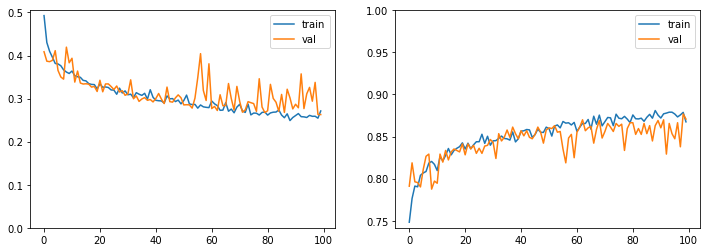

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6137 - accuracy: 0.6837 - precision: 0.8763 - recall: 0.6755 - f1: 0.7560 - specificity: 0.7175 - negative_predictive_value: 0.4337 - matthews_correlation_coefficient: 0.3481 - val_loss: 0.5722 - val_accuracy: 0.7016 - val_precision: 0.8754 - val_recall: 0.6593 - val_f1: 0.7469 - val_specificity: 0.7922 - val_negative_predictive_value: 0.4686 - val_matthews_correlation_coefficient: 0.3917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39174, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_26-02_19_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5986 - accuracy: 0.6937 - precision: 0.8914 - recall: 0.6750 - f1: 0.7635 - specificity: 0.7587 - negative_predictive_value: 0.4392 - matthews_correlation_coefficient: 0.3763 - val_loss: 0.5542 - val_accuracy: 0.7016 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5823 - accuracy: 0.6920 - precision: 0.8968 - recall: 0.6612 - f1: 0.7576 - specificity: 0.7693 - negative_predictive_value: 0.4377 - matthews_correlation_coefficient: 0.3794 - val_loss: 0.5973 - val_accuracy: 0.6826 - val_precision: 0.8821 - val_recall: 0.6227 - val_f1: 0.7258 - val_specificity: 0.8218 - val_negative_predictive_value: 0.4522 - val_matthews_correlation_coefficient: 0.3833

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39564
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5809 - accuracy: 0.6952 - precision: 0.8950 - recall: 0.6725 - f1: 0.7642 - specificity: 0.7707 - negative_predictive_value: 0.4417 - matthews_correlation_coefficient: 0.3846 - val_loss: 0.5889 - val_accuracy: 0.6947 - val_precision: 0.8808 - val_recall: 0.6441 - val_f1: 0.7392 - val_specificity: 0.8088 - val_negative_predictive_value: 0.4634 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39620
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5785 - accuracy: 0.6972 - precision: 0.8986 - recall: 0.6673 - f1: 0.7619 - specificity: 0.7793 - negative_predictive_value: 0.4450 - matthews_correlation_coefficient: 0.3913 - val_loss: 0.5730 - val_accuracy: 0.6930 - val_precision: 0.8766 - val_recall: 0.6447 - val_f1: 0.7381 - val_specificity: 0.8034 - val_negative_predictive_value: 0.4607 - val_matthews_correlation_coefficient: 0.3865

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.39620
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5755 - accuracy: 0.6976 - precision: 0.8973 - recall: 0.6703 - f1: 0.7625 - specificity: 0.7842 - negative_predictive_value: 0.4442 - matthews_correlation_coefficient: 0.3937 - val_loss: 0.6409 - val_accuracy: 0.6670 - val_precision: 0.8890 - val_recall: 0.5950 - val_f1: 0.7085 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39620
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5741 - accuracy: 0.6924 - precision: 0.8970 - recall: 0.6616 - f1: 0.7562 - specificity: 0.7887 - negative_predictive_value: 0.4415 - matthews_correlation_coefficient: 0.3905 - val_loss: 0.5791 - val_accuracy: 0.6808 - val_precision: 0.8741 - val_recall: 0.6281 - val_f1: 0.7265 - val_specificity: 0.8043 - val_negative_predictive_value: 0.4511 - val_matthews_correlation_coefficient: 0.3728

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.39620
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5764 - accuracy: 0.6896 - precision: 0.8911 - recall: 0.6532 - f1: 0.7495 - specificity: 0.7842 - negative_predictive_value: 0.4440 - matthews_correlation_coefficient: 0.3827 - val_loss: 0.5626 - val_accuracy: 0.6895 - val_precision: 0.8703 - val_recall: 0.6444 - val_f1: 0.7358 - val_spe

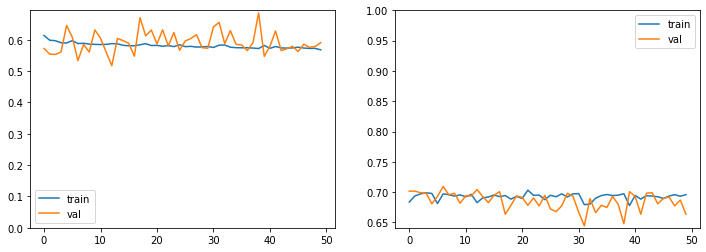

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6254 - accuracy: 0.6640 - precision: 0.6826 - recall: 0.6606 - f1: 0.6376 - specificity: 0.6520 - negative_predictive_value: 0.6823 - matthews_correlation_coefficient: 0.3418 - val_loss: 0.6057 - val_accuracy: 0.6253 - val_precision: 0.6973 - val_recall: 0.4290 - val_f1: 0.5219 - val_specificity: 0.8047 - val_negative_predictive_value: 0.5644 - val_matthews_correlation_coefficient: 0.2739

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27389, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_26-02_26_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5797 - accuracy: 0.7037 - precision: 0.7017 - recall: 0.7682 - f1: 0.7215 - specificity: 0.6355 - negative_predictive_value: 0.7253 - matthews_correlation_coefficient: 0.4163 - val_loss: 0.5677 - val_accuracy: 0.6973 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4887 - accuracy: 0.7469 - precision: 0.7283 - recall: 0.7973 - f1: 0.7544 - specificity: 0.6884 - negative_predictive_value: 0.7687 - matthews_correlation_coefficient: 0.4924 - val_loss: 0.4824 - val_accuracy: 0.7624 - val_precision: 0.7391 - val_recall: 0.7604 - val_f1: 0.7450 - val_specificity: 0.7226 - val_negative_predictive_value: 0.7428 - val_matthews_correlation_coefficient: 0.5092

Epoch 00014: val_matthews_correlation_coefficient improved from 0.49070 to 0.50917, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_26-02_26_52.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4868 - accuracy: 0.7534 - precision: 0.7409 - recall: 0.7911 - f1: 0.7587 - specificity: 0.7074 - negative_predictive_value: 0.7725 - matthews_correlation_coefficient: 0.5073 - val_loss: 0.5037 - val_accuracy: 0.7372 - val_precision: 0.7746 - val_recall: 0.6434 - val_f1: 0.69

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4680 - accuracy: 0.7597 - precision: 0.7590 - recall: 0.7884 - f1: 0.7656 - specificity: 0.7256 - negative_predictive_value: 0.7670 - matthews_correlation_coefficient: 0.5214 - val_loss: 0.4753 - val_accuracy: 0.7624 - val_precision: 0.7238 - val_recall: 0.8984 - val_f1: 0.7971 - val_specificity: 0.6017 - val_negative_predictive_value: 0.8163 - val_matthews_correlation_coefficient: 0.5189

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.52566
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4771 - accuracy: 0.7638 - precision: 0.7553 - recall: 0.8131 - f1: 0.7759 - specificity: 0.7164 - negative_predictive_value: 0.7878 - matthews_correlation_coefficient: 0.5356 - val_loss: 0.5441 - val_accuracy: 0.7086 - val_precision: 0.7247 - val_recall: 0.6416 - val_f1: 0.6751 - val_specificity: 0.7383 - val_negative_predictive_value: 0.6553 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient improved from 0.52844 to 0.55164, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_26-02_26_52.h5
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4515 - accuracy: 0.7777 - precision: 0.7694 - recall: 0.8064 - f1: 0.7795 - specificity: 0.7489 - negative_predictive_value: 0.7907 - matthews_correlation_coefficient: 0.5591 - val_loss: 0.4982 - val_accuracy: 0.7381 - val_precision: 0.7450 - val_recall: 0.6866 - val_f1: 0.7089 - val_specificity: 0.7513 - val_negative_predictive_value: 0.6907 - val_matthews_correlation_coefficient: 0.4636

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.55164
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4446 - accuracy: 0.7779 - precision: 0.7844 - recall: 0.8026 - f1: 0.7854 - specificity: 0.7582 - negative_predictive_value: 0.7820 - matthews_correlation_coefficient: 0.5633 - val_lo


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.55164
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4339 - accuracy: 0.7902 - precision: 0.7913 - recall: 0.8121 - f1: 0.7955 - specificity: 0.7616 - negative_predictive_value: 0.7902 - matthews_correlation_coefficient: 0.5771 - val_loss: 0.4856 - val_accuracy: 0.7493 - val_precision: 0.7504 - val_recall: 0.7136 - val_f1: 0.7258 - val_specificity: 0.7456 - val_negative_predictive_value: 0.7077 - val_matthews_correlation_coefficient: 0.4854

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.55164
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4378 - accuracy: 0.7811 - precision: 0.7825 - recall: 0.8083 - f1: 0.7878 - specificity: 0.7591 - negative_predictive_value: 0.7886 - matthews_correlation_coefficient: 0.5689 - val_loss: 0.4613 - val_accuracy: 0.7745 - val_precision: 0.7584 - val_recall: 0.7634 - val_f1: 0.7565 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.55651
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4173 - accuracy: 0.7920 - precision: 0.7890 - recall: 0.8067 - f1: 0.7907 - specificity: 0.7645 - negative_predictive_value: 0.7917 - matthews_correlation_coefficient: 0.5826 - val_loss: 0.4687 - val_accuracy: 0.7728 - val_precision: 0.7475 - val_recall: 0.7828 - val_f1: 0.7601 - val_specificity: 0.7177 - val_negative_predictive_value: 0.7542 - val_matthews_correlation_coefficient: 0.5280

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.55651
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4399 - accuracy: 0.7879 - precision: 0.7851 - recall: 0.8261 - f1: 0.7963 - specificity: 0.7529 - negative_predictive_value: 0.8094 - matthews_correlation_coefficient: 0.5858 - val_loss: 0.4443 - val_accuracy: 0.7866 - val_precision: 0.7774 - val_recall: 0.7655 - val_f1: 0.7660 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4167 - accuracy: 0.8043 - precision: 0.8098 - recall: 0.8166 - f1: 0.8054 - specificity: 0.7954 - negative_predictive_value: 0.8106 - matthews_correlation_coefficient: 0.6159 - val_loss: 0.4692 - val_accuracy: 0.7702 - val_precision: 0.7747 - val_recall: 0.7286 - val_f1: 0.7449 - val_specificity: 0.7767 - val_negative_predictive_value: 0.7267 - val_matthews_correlation_coefficient: 0.5302

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.56759
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4183 - accuracy: 0.8039 - precision: 0.8115 - recall: 0.8151 - f1: 0.8048 - specificity: 0.8005 - negative_predictive_value: 0.8034 - matthews_correlation_coefficient: 0.6148 - val_loss: 0.4886 - val_accuracy: 0.7710 - val_precision: 0.7649 - val_recall: 0.8226 - val_f1: 0.7875 - val_specificity: 0.7003 - val_negative_predictive_value: 0.7626 - val_matthews_correlation_coefficie

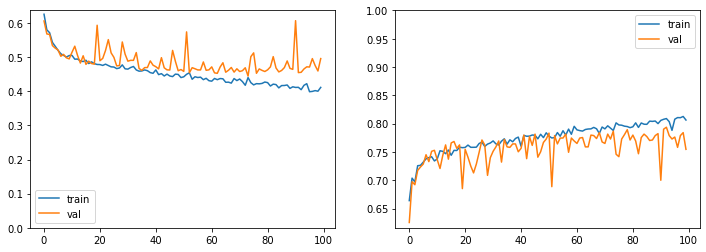

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6420 - accuracy: 0.5393 - precision: 0.9053 - recall: 0.4748 - f1: 0.6082 - specificity: 0.7902 - negative_predictive_value: 0.2833 - matthews_correlation_coefficient: 0.2231 - val_loss: 0.6700 - val_accuracy: 0.4866 - val_precision: 0.9255 - val_recall: 0.4017 - val_f1: 0.5470 - val_specificity: 0.8483 - val_negative_predictive_value: 0.2687 - val_matthews_correlation_coefficient: 0.2182

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21822, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_26-02_41_41.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6198 - accuracy: 0.5538 - precision: 0.9111 - recall: 0.4806 - f1: 0.6157 - specificity: 0.8116 - negative_predictive_value: 0.2953 - matthews_correlation_coefficient: 0.2507 - val_loss: 0.6642 - val_accuracy: 0.5403 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5794 - accuracy: 0.6356 - precision: 0.9260 - recall: 0.5917 - f1: 0.7121 - specificity: 0.8056 - negative_predictive_value: 0.3504 - matthews_correlation_coefficient: 0.3304 - val_loss: 0.6525 - val_accuracy: 0.5698 - val_precision: 0.9287 - val_recall: 0.5091 - val_f1: 0.6488 - val_specificity: 0.8281 - val_negative_predictive_value: 0.3038 - val_matthews_correlation_coefficient: 0.2782

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.31883
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.6547 - precision: 0.9236 - recall: 0.6172 - f1: 0.7317 - specificity: 0.7954 - negative_predictive_value: 0.3593 - matthews_correlation_coefficient: 0.3401 - val_loss: 0.5938 - val_accuracy: 0.6288 - val_precision: 0.9223 - val_recall: 0.5928 - val_f1: 0.7152 - val_specificity: 0.7841 - val_negative_predictive_value: 0.3348 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5529 - accuracy: 0.6751 - precision: 0.9263 - recall: 0.6479 - f1: 0.7493 - specificity: 0.7768 - negative_predictive_value: 0.3855 - matthews_correlation_coefficient: 0.3635 - val_loss: 0.5124 - val_accuracy: 0.7285 - val_precision: 0.9132 - val_recall: 0.7368 - val_f1: 0.8115 - val_specificity: 0.6954 - val_negative_predictive_value: 0.4052 - val_matthews_correlation_coefficient: 0.3693

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38191
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5395 - accuracy: 0.6796 - precision: 0.9207 - recall: 0.6446 - f1: 0.7514 - specificity: 0.7985 - negative_predictive_value: 0.3815 - matthews_correlation_coefficient: 0.3635 - val_loss: 0.5758 - val_accuracy: 0.6635 - val_precision: 0.9273 - val_recall: 0.6375 - val_f1: 0.7496 - val_specificity: 0.7687 - val_negative_predictive_value: 0.3525 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39007
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5263 - accuracy: 0.6983 - precision: 0.9217 - recall: 0.6816 - f1: 0.7753 - specificity: 0.7860 - negative_predictive_value: 0.3972 - matthews_correlation_coefficient: 0.3843 - val_loss: 0.5784 - val_accuracy: 0.6513 - val_precision: 0.9303 - val_recall: 0.6177 - val_f1: 0.7355 - val_specificity: 0.7956 - val_negative_predictive_value: 0.3525 - val_matthews_correlation_coefficient: 0.3401

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39007
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5187 - accuracy: 0.7145 - precision: 0.9274 - recall: 0.6956 - f1: 0.7879 - specificity: 0.7785 - negative_predictive_value: 0.4150 - matthews_correlation_coefficient: 0.4004 - val_loss: 0.6222 - val_accuracy: 0.6496 - val_precision: 0.9337 - val_recall: 0.6130 - val_f1: 0.7316 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39007
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5092 - accuracy: 0.7247 - precision: 0.9298 - recall: 0.7134 - f1: 0.7999 - specificity: 0.7936 - negative_predictive_value: 0.4308 - matthews_correlation_coefficient: 0.4234 - val_loss: 0.5539 - val_accuracy: 0.6973 - val_precision: 0.9311 - val_recall: 0.6790 - val_f1: 0.7797 - val_specificity: 0.7662 - val_negative_predictive_value: 0.3840 - val_matthews_correlation_coefficient: 0.3729

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39007
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5042 - accuracy: 0.7375 - precision: 0.9207 - recall: 0.7242 - f1: 0.8045 - specificity: 0.7677 - negative_predictive_value: 0.4355 - matthews_correlation_coefficient: 0.4149 - val_loss: 0.6672 - val_accuracy: 0.6028 - val_precision: 0.9298 - val_recall: 0.5515 - val_f1: 0.6835 - val_spe

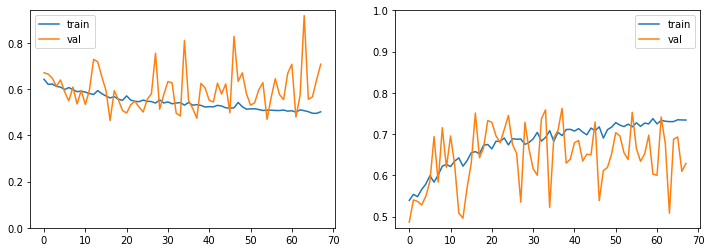

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4717 - accuracy: 0.7560 - precision: 0.8653 - recall: 0.7554 - f1: 0.7976 - specificity: 0.7718 - negative_predictive_value: 0.6147 - matthews_correlation_coefficient: 0.5071 - val_loss: 0.4114 - val_accuracy: 0.7797 - val_precision: 0.8463 - val_recall: 0.7581 - val_f1: 0.7975 - val_specificity: 0.7528 - val_negative_predictive_value: 0.6293 - val_matthews_correlation_coefficient: 0.5195

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.51948, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_26-02_51_47.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4207 - accuracy: 0.7881 - precision: 0.8980 - recall: 0.7684 - f1: 0.8229 - specificity: 0.8324 - negative_predictive_value: 0.6524 - matthews_correlation_coefficient: 0.5739 - val_loss: 0.5008 - val_accuracy: 0.7415 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3665 - accuracy: 0.8223 - precision: 0.9168 - recall: 0.8041 - f1: 0.8531 - specificity: 0.8620 - negative_predictive_value: 0.6918 - matthews_correlation_coefficient: 0.6356 - val_loss: 0.3463 - val_accuracy: 0.8413 - val_precision: 0.8906 - val_recall: 0.8731 - val_f1: 0.8800 - val_specificity: 0.7533 - val_negative_predictive_value: 0.7288 - val_matthews_correlation_coefficient: 0.6223

Epoch 00014: val_matthews_correlation_coefficient improved from 0.61689 to 0.62226, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_26-02_51_47.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3663 - accuracy: 0.8269 - precision: 0.9187 - recall: 0.8132 - f1: 0.8581 - specificity: 0.8636 - negative_predictive_value: 0.7039 - matthews_correlation_coefficient: 0.6475 - val_loss: 0.3285 - val_accuracy: 0.8517 - val_precision: 0.8813 - val_recall: 0.9023 - val_f1: 0.8892 - 


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.66934
Epoch 28/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3425 - accuracy: 0.8477 - precision: 0.9226 - recall: 0.8424 - f1: 0.8771 - specificity: 0.8543 - negative_predictive_value: 0.7355 - matthews_correlation_coefficient: 0.6756 - val_loss: 0.3126 - val_accuracy: 0.8578 - val_precision: 0.9016 - val_recall: 0.8834 - val_f1: 0.8907 - val_specificity: 0.7868 - val_negative_predictive_value: 0.7565 - val_matthews_correlation_coefficient: 0.6636

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.66934
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3357 - accuracy: 0.8473 - precision: 0.9247 - recall: 0.8346 - f1: 0.8741 - specificity: 0.8661 - negative_predictive_value: 0.7337 - matthews_correlation_coefficient: 0.6799 - val_loss: 0.3258 - val_accuracy: 0.8387 - val_precision: 0.8363 - val_recall: 0.9443 - val_f1: 0.8853 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3261 - accuracy: 0.8525 - precision: 0.9170 - recall: 0.8407 - f1: 0.8740 - specificity: 0.8656 - negative_predictive_value: 0.7418 - matthews_correlation_coefficient: 0.6873 - val_loss: 0.3617 - val_accuracy: 0.8257 - val_precision: 0.9320 - val_recall: 0.7463 - val_f1: 0.8263 - val_specificity: 0.9135 - val_negative_predictive_value: 0.6625 - val_matthews_correlation_coefficient: 0.6521

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.70655
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3573 - accuracy: 0.8289 - precision: 0.9197 - recall: 0.8137 - f1: 0.8558 - specificity: 0.8605 - negative_predictive_value: 0.7152 - matthews_correlation_coefficient: 0.6543 - val_loss: 0.3344 - val_accuracy: 0.8534 - val_precision: 0.9375 - val_recall: 0.8346 - val_f1: 0.8812 - val_specificity: 0.8630 - val_negative_predictive_value: 0.7145 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3097 - accuracy: 0.8603 - precision: 0.9311 - recall: 0.8532 - f1: 0.8877 - specificity: 0.8758 - negative_predictive_value: 0.7527 - matthews_correlation_coefficient: 0.7053 - val_loss: 0.2795 - val_accuracy: 0.8708 - val_precision: 0.8861 - val_recall: 0.9262 - val_f1: 0.9039 - val_specificity: 0.7399 - val_negative_predictive_value: 0.8221 - val_matthews_correlation_coefficient: 0.6856

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.70655
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3103 - accuracy: 0.8614 - precision: 0.9207 - recall: 0.8539 - f1: 0.8822 - specificity: 0.8703 - negative_predictive_value: 0.7712 - matthews_correlation_coefficient: 0.7067 - val_loss: 0.2812 - val_accuracy: 0.8716 - val_precision: 0.8948 - val_recall: 0.9163 - val_f1: 0.9041 - val_specificity: 0.7605 - val_negative_predictive_value: 0.7994 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.72394
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2977 - accuracy: 0.8677 - precision: 0.9299 - recall: 0.8665 - f1: 0.8940 - specificity: 0.8676 - negative_predictive_value: 0.7728 - matthews_correlation_coefficient: 0.7173 - val_loss: 0.2888 - val_accuracy: 0.8664 - val_precision: 0.9222 - val_recall: 0.8717 - val_f1: 0.8943 - val_specificity: 0.8302 - val_negative_predictive_value: 0.7572 - val_matthews_correlation_coefficient: 0.6901

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.72394
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3002 - accuracy: 0.8729 - precision: 0.9288 - recall: 0.8725 - f1: 0.8960 - specificity: 0.8682 - negative_predictive_value: 0.7784 - matthews_correlation_coefficient: 0.7240 - val_loss: 0.3317 - val_accuracy: 0.8430 - val_precision: 0.9269 - val_recall: 0.7786 - val_f1: 0.8439 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.72394
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2912 - accuracy: 0.8711 - precision: 0.9340 - recall: 0.8617 - f1: 0.8931 - specificity: 0.8795 - negative_predictive_value: 0.7710 - matthews_correlation_coefficient: 0.7239 - val_loss: 0.2975 - val_accuracy: 0.8647 - val_precision: 0.9405 - val_recall: 0.8511 - val_f1: 0.8917 - val_specificity: 0.8615 - val_negative_predictive_value: 0.7329 - val_matthews_correlation_coefficient: 0.6921

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.72394
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2844 - accuracy: 0.8709 - precision: 0.9279 - recall: 0.8611 - f1: 0.8899 - specificity: 0.8853 - negative_predictive_value: 0.7779 - matthews_correlation_coefficient: 0.7243 - val_loss: 0.2745 - val_accuracy: 0.8777 - val_precision: 0.9069 - val_recall: 0.9104 - val_f1: 0.9069 - val_spe

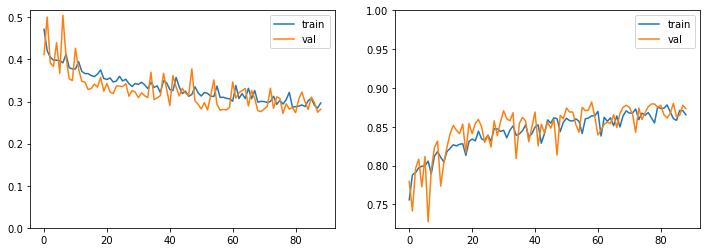

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6440 - accuracy: 0.6245 - precision: 0.8229 - recall: 0.6182 - f1: 0.6786 - specificity: 0.6442 - negative_predictive_value: 0.4046 - matthews_correlation_coefficient: 0.2495 - val_loss: 0.5349 - val_accuracy: 0.7424 - val_precision: 0.7747 - val_recall: 0.8517 - val_f1: 0.8088 - val_specificity: 0.3895 - val_negative_predictive_value: 0.5369 - val_matthews_correlation_coefficient: 0.2704

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27043, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_26-03_05_10.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6213 - accuracy: 0.6536 - precision: 0.8460 - recall: 0.6459 - f1: 0.7209 - specificity: 0.6602 - negative_predictive_value: 0.4115 - matthews_correlation_coefficient: 0.2861 - val_loss: 0.6084 - val_accuracy: 0.6860 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.41491
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5430 - accuracy: 0.7197 - precision: 0.8856 - recall: 0.7164 - f1: 0.7840 - specificity: 0.7332 - negative_predictive_value: 0.4853 - matthews_correlation_coefficient: 0.4068 - val_loss: 0.4994 - val_accuracy: 0.7554 - val_precision: 0.8276 - val_recall: 0.7913 - val_f1: 0.8059 - val_specificity: 0.6129 - val_negative_predictive_value: 0.5449 - val_matthews_correlation_coefficient: 0.3863

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.41491
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5358 - accuracy: 0.7386 - precision: 0.8859 - recall: 0.7438 - f1: 0.8028 - specificity: 0.7280 - negative_predictive_value: 0.5130 - matthews_correlation_coefficient: 0.4312 - val_loss: 0.6291 - val_accuracy: 0.6678 - val_precision: 0.8961 - val_recall: 0.5874 - val_f1: 0.7044 - val_spe


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.45816
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5102 - accuracy: 0.7434 - precision: 0.8927 - recall: 0.7333 - f1: 0.7987 - specificity: 0.7544 - negative_predictive_value: 0.5120 - matthews_correlation_coefficient: 0.4442 - val_loss: 0.6181 - val_accuracy: 0.6921 - val_precision: 0.8819 - val_recall: 0.6318 - val_f1: 0.7312 - val_specificity: 0.8217 - val_negative_predictive_value: 0.4702 - val_matthews_correlation_coefficient: 0.3979

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.45816
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5214 - accuracy: 0.7315 - precision: 0.8907 - recall: 0.7250 - f1: 0.7929 - specificity: 0.7332 - negative_predictive_value: 0.5011 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.4904 - val_accuracy: 0.7667 - val_precision: 0.8221 - val_recall: 0.8179 - val_f1: 0.8162 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45879
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4896 - accuracy: 0.7586 - precision: 0.9005 - recall: 0.7587 - f1: 0.8167 - specificity: 0.7692 - negative_predictive_value: 0.5355 - matthews_correlation_coefficient: 0.4785 - val_loss: 0.5080 - val_accuracy: 0.7546 - val_precision: 0.8575 - val_recall: 0.7517 - val_f1: 0.7969 - val_specificity: 0.7294 - val_negative_predictive_value: 0.5504 - val_matthews_correlation_coefficient: 0.4411

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45879
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4938 - accuracy: 0.7482 - precision: 0.8964 - recall: 0.7380 - f1: 0.8029 - specificity: 0.7666 - negative_predictive_value: 0.5212 - matthews_correlation_coefficient: 0.4569 - val_loss: 0.6058 - val_accuracy: 0.7008 - val_precision: 0.8964 - val_recall: 0.6356 - val_f1: 0.7395 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48578
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4839 - accuracy: 0.7549 - precision: 0.9045 - recall: 0.7462 - f1: 0.8118 - specificity: 0.7744 - negative_predictive_value: 0.5303 - matthews_correlation_coefficient: 0.4752 - val_loss: 0.5409 - val_accuracy: 0.7216 - val_precision: 0.8744 - val_recall: 0.6855 - val_f1: 0.7648 - val_specificity: 0.7859 - val_negative_predictive_value: 0.5008 - val_matthews_correlation_coefficient: 0.4189

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.48578
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4780 - accuracy: 0.7638 - precision: 0.8982 - recall: 0.7543 - f1: 0.8151 - specificity: 0.7744 - negative_predictive_value: 0.5405 - matthews_correlation_coefficient: 0.4861 - val_loss: 0.4929 - val_accuracy: 0.7537 - val_precision: 0.8604 - val_recall: 0.7456 - val_f1: 0.7960 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.49092
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4682 - accuracy: 0.7711 - precision: 0.9083 - recall: 0.7711 - f1: 0.8289 - specificity: 0.7880 - negative_predictive_value: 0.5579 - matthews_correlation_coefficient: 0.5078 - val_loss: 0.5609 - val_accuracy: 0.7095 - val_precision: 0.8891 - val_recall: 0.6535 - val_f1: 0.7490 - val_specificity: 0.8354 - val_negative_predictive_value: 0.4887 - val_matthews_correlation_coefficient: 0.4282

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.49092
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4483 - accuracy: 0.7735 - precision: 0.9165 - recall: 0.7635 - f1: 0.8281 - specificity: 0.7961 - negative_predictive_value: 0.5507 - matthews_correlation_coefficient: 0.5109 - val_loss: 0.4537 - val_accuracy: 0.7927 - val_precision: 0.8422 - val_recall: 0.8293 - val_f1: 0.8329 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.49092
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4518 - accuracy: 0.7729 - precision: 0.9151 - recall: 0.7671 - f1: 0.8297 - specificity: 0.8012 - negative_predictive_value: 0.5587 - matthews_correlation_coefficient: 0.5164 - val_loss: 0.4589 - val_accuracy: 0.7875 - val_precision: 0.8446 - val_recall: 0.8169 - val_f1: 0.8279 - val_specificity: 0.6643 - val_negative_predictive_value: 0.6005 - val_matthews_correlation_coefficient: 0.4600

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.49092
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4520 - accuracy: 0.7770 - precision: 0.9159 - recall: 0.7670 - f1: 0.8300 - specificity: 0.7938 - negative_predictive_value: 0.5555 - matthews_correlation_coefficient: 0.5136 - val_loss: 0.4771 - val_accuracy: 0.7840 - val_precision: 0.8480 - val_recall: 0.8054 - val_f1: 0.8241 - val_spe

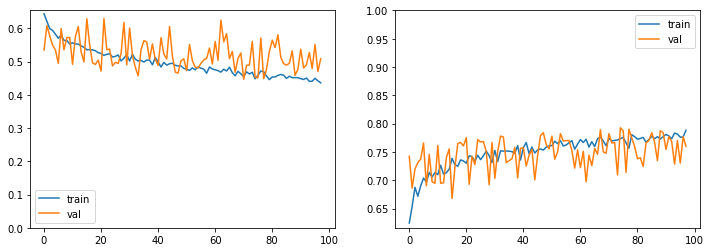

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5776 - accuracy: 0.5362 - precision: 0.9630 - recall: 0.4917 - f1: 0.6452 - specificity: 0.8576 - negative_predictive_value: 0.1822 - matthews_correlation_coefficient: 0.2254 - val_loss: 0.7165 - val_accuracy: 0.4657 - val_precision: 0.9556 - val_recall: 0.3949 - val_f1: 0.5530 - val_specificity: 0.9316 - val_negative_predictive_value: 0.1866 - val_matthews_correlation_coefficient: 0.2134

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21341, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_26-03_19_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.5644 - precision: 0.9672 - recall: 0.5310 - f1: 0.6773 - specificity: 0.8021 - negative_predictive_value: 0.1880 - matthews_correlation_coefficient: 0.2286 - val_loss: 0.5532 - val_accuracy: 0.5256 - val_pre


Epoch 00014: val_matthews_correlation_coefficient improved from 0.31574 to 0.32630, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_26-03_19_37.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4531 - accuracy: 0.7184 - precision: 0.9659 - recall: 0.6996 - f1: 0.8051 - specificity: 0.8323 - negative_predictive_value: 0.2765 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5992 - val_accuracy: 0.6193 - val_precision: 0.9542 - val_recall: 0.5650 - val_f1: 0.7052 - val_specificity: 0.9077 - val_negative_predictive_value: 0.2354 - val_matthews_correlation_coefficient: 0.2939

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32630
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4412 - accuracy: 0.7230 - precision: 0.9746 - recall: 0.7101 - f1: 0.8156 - specificity: 0.8325 - negative_predictive_value: 0.2776 - matthews_correlation_coefficient: 0.3617 - val_loss: 0.


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3900 - accuracy: 0.7707 - precision: 0.9836 - recall: 0.7538 - f1: 0.8487 - specificity: 0.8725 - negative_predictive_value: 0.3243 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.3865 - val_accuracy: 0.7832 - val_precision: 0.9473 - val_recall: 0.7567 - val_f1: 0.8385 - val_specificity: 0.8082 - val_negative_predictive_value: 0.3182 - val_matthews_correlation_coefficient: 0.4066

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7657 - precision: 0.9779 - recall: 0.7569 - f1: 0.8476 - specificity: 0.8568 - negative_predictive_value: 0.3330 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.4464 - val_accuracy: 0.7398 - val_precision: 0.9582 - val_recall: 0.6975 - val_f1: 0.8049 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3917 - accuracy: 0.7740 - precision: 0.9801 - recall: 0.7617 - f1: 0.8490 - specificity: 0.8286 - negative_predictive_value: 0.3388 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.4029 - val_accuracy: 0.7580 - val_precision: 0.9664 - val_recall: 0.7112 - val_f1: 0.8166 - val_specificity: 0.9358 - val_negative_predictive_value: 0.3258 - val_matthews_correlation_coefficient: 0.4271

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3711 - accuracy: 0.7720 - precision: 0.9814 - recall: 0.7604 - f1: 0.8522 - specificity: 0.8684 - negative_predictive_value: 0.3247 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.3138 - val_accuracy: 0.8404 - val_precision: 0.9490 - val_recall: 0.8183 - val_f1: 0.8779 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.7692 - precision: 0.9765 - recall: 0.7496 - f1: 0.8405 - specificity: 0.8502 - negative_predictive_value: 0.3389 - matthews_correlation_coefficient: 0.4289 - val_loss: 0.6904 - val_accuracy: 0.6271 - val_precision: 0.9713 - val_recall: 0.5638 - val_f1: 0.7092 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2442 - val_matthews_correlation_coefficient: 0.3333

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3834 - accuracy: 0.7711 - precision: 0.9807 - recall: 0.7553 - f1: 0.8455 - specificity: 0.8507 - negative_predictive_value: 0.3412 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.4416 - val_accuracy: 0.7398 - val_precision: 0.9688 - val_recall: 0.6891 - val_f1: 0.8027 - val_specificity: 0.9562 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3363 - accuracy: 0.8087 - precision: 0.9832 - recall: 0.8005 - f1: 0.8779 - specificity: 0.8717 - negative_predictive_value: 0.3681 - matthews_correlation_coefficient: 0.4772 - val_loss: 0.5905 - val_accuracy: 0.6791 - val_precision: 0.9713 - val_recall: 0.6208 - val_f1: 0.7540 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2704 - val_matthews_correlation_coefficient: 0.3714

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3366 - accuracy: 0.8078 - precision: 0.9824 - recall: 0.7990 - f1: 0.8760 - specificity: 0.8469 - negative_predictive_value: 0.3832 - matthews_correlation_coefficient: 0.4750 - val_loss: 0.7185 - val_accuracy: 0.6219 - val_precision: 0.9712 - val_recall: 0.5583 - val_f1: 0.7052 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2426 - val_matthews_correlation_coefficie

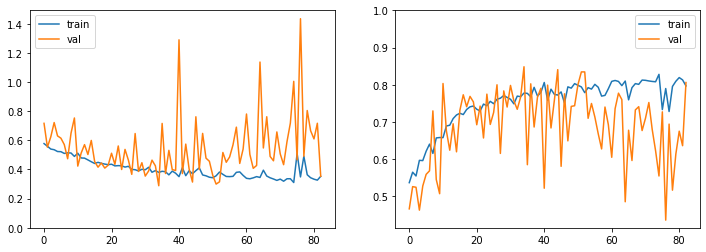

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5811 - accuracy: 0.6584 - precision: 0.9013 - recall: 0.6385 - f1: 0.7399 - specificity: 0.7576 - negative_predictive_value: 0.3587 - matthews_correlation_coefficient: 0.3227 - val_loss: 0.6597 - val_accuracy: 0.6236 - val_precision: 0.8963 - val_recall: 0.5572 - val_f1: 0.6843 - val_specificity: 0.8012 - val_negative_predictive_value: 0.3311 - val_matthews_correlation_coefficient: 0.3118

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31177, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_26-03_31_57.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5702 - accuracy: 0.6861 - precision: 0.8989 - recall: 0.6819 - f1: 0.7679 - specificity: 0.7005 - negative_predictive_value: 0.3767 - matthews_correlation_coefficient: 0.3235 - val_loss: 0.5963 - val_accuracy: 0.6765 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5263 - accuracy: 0.6972 - precision: 0.9172 - recall: 0.6795 - f1: 0.7749 - specificity: 0.7564 - negative_predictive_value: 0.3897 - matthews_correlation_coefficient: 0.3643 - val_loss: 0.5965 - val_accuracy: 0.6227 - val_precision: 0.9223 - val_recall: 0.5394 - val_f1: 0.6743 - val_specificity: 0.8663 - val_negative_predictive_value: 0.3424 - val_matthews_correlation_coefficient: 0.3535

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36538
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5201 - accuracy: 0.7095 - precision: 0.9206 - recall: 0.6929 - f1: 0.7851 - specificity: 0.7576 - negative_predictive_value: 0.3990 - matthews_correlation_coefficient: 0.3779 - val_loss: 0.5645 - val_accuracy: 0.6912 - val_precision: 0.8882 - val_recall: 0.6570 - val_f1: 0.7508 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5105 - accuracy: 0.7041 - precision: 0.9259 - recall: 0.6865 - f1: 0.7802 - specificity: 0.7848 - negative_predictive_value: 0.4086 - matthews_correlation_coefficient: 0.3949 - val_loss: 0.4774 - val_accuracy: 0.7441 - val_precision: 0.8914 - val_recall: 0.7271 - val_f1: 0.7970 - val_specificity: 0.7131 - val_negative_predictive_value: 0.4326 - val_matthews_correlation_coefficient: 0.4030

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.42223
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4984 - accuracy: 0.7286 - precision: 0.9231 - recall: 0.7085 - f1: 0.7953 - specificity: 0.7841 - negative_predictive_value: 0.4368 - matthews_correlation_coefficient: 0.4186 - val_loss: 0.5114 - val_accuracy: 0.6895 - val_precision: 0.9078 - val_recall: 0.6369 - val_f1: 0.7421 - val_specificity: 0.8021 - val_negative_predictive_value: 0.3922 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.46169
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4761 - accuracy: 0.7401 - precision: 0.9325 - recall: 0.7288 - f1: 0.8131 - specificity: 0.8008 - negative_predictive_value: 0.4462 - matthews_correlation_coefficient: 0.4435 - val_loss: 0.5226 - val_accuracy: 0.6938 - val_precision: 0.9052 - val_recall: 0.6439 - val_f1: 0.7462 - val_specificity: 0.7987 - val_negative_predictive_value: 0.3993 - val_matthews_correlation_coefficient: 0.3929

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46169
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4738 - accuracy: 0.7403 - precision: 0.9289 - recall: 0.7302 - f1: 0.8121 - specificity: 0.7802 - negative_predictive_value: 0.4409 - matthews_correlation_coefficient: 0.4320 - val_loss: 0.4599 - val_accuracy: 0.7589 - val_precision: 0.8994 - val_recall: 0.7362 - val_f1: 0.8051 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46169
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4766 - accuracy: 0.7499 - precision: 0.9306 - recall: 0.7437 - f1: 0.8203 - specificity: 0.7935 - negative_predictive_value: 0.4624 - matthews_correlation_coefficient: 0.4549 - val_loss: 0.5795 - val_accuracy: 0.6565 - val_precision: 0.9303 - val_recall: 0.5780 - val_f1: 0.7059 - val_specificity: 0.8811 - val_negative_predictive_value: 0.3689 - val_matthews_correlation_coefficient: 0.3962

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46169
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4518 - accuracy: 0.7597 - precision: 0.9239 - recall: 0.7489 - f1: 0.8234 - specificity: 0.7917 - negative_predictive_value: 0.4631 - matthews_correlation_coefficient: 0.4554 - val_loss: 0.6671 - val_accuracy: 0.6314 - val_precision: 0.9270 - val_recall: 0.5484 - val_f1: 0.6813 - val_spe

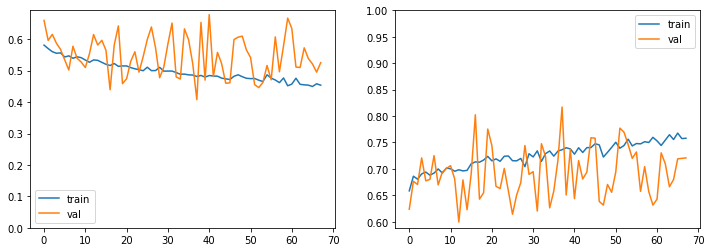

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_26-03_42_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1661 - accuracy: 0.8989 - precision: 1.0000 - recall: 0.8993 - f1: 0.9456 - specificity: 0.0966 - negative_predictive_value: 0.0336 - matthews_correlation_coefficient: 0.0542 - val_loss: 0.1927 - val_accuracy: 0.9150 - val_precision: 1.0000 - val_recall: 0.9170 - val_f1: 0.9559 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficient: 0.0655

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1302 - accuracy: 0.9243 - precision: 1.0000 - recall: 0.9246 - f1: 0.9601 - specificity: 0.0966 - negative_predictive_value: 0.0425 - matthews_correlation_coefficient: 0.0588 - val_loss: 0.0631 - val_accuracy: 0.9679 - val_precision: 1.0000 - val_recall: 0.9687 - val_f1: 0.9837 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_26-03_42_03.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1733 - accuracy: 0.9158 - precision: 0.9998 - recall: 0.9164 - f1: 0.9541 - specificity: 0.0966 - negative_predictive_value: 0.0558 - matthews_correlation_coefficient: 0.0667 - val_loss: 0.2972 - val_accuracy: 0.9124 - val_precision: 1.0000 - val_recall: 0.9144 - val_f1: 0.9543 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0459 - val_matthews_correlation_coefficient: 0.0635

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1553 - accuracy: 0.9165 - precision: 1.0000 - recall: 0.9168 - f1: 0.9556 - specificity: 0.0966 - negative_predictive_value: 0.0397 - matthews_correlation_coefficient: 0.0570 - val_loss: 0.13


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0977 - accuracy: 0.9542 - precision: 1.0000 - recall: 0.9544 - f1: 0.9762 - specificity: 0.1034 - negative_predictive_value: 0.0589 - matthews_correlation_coefficient: 0.0747 - val_loss: 0.1622 - val_accuracy: 0.9410 - val_precision: 1.0000 - val_recall: 0.9425 - val_f1: 0.9698 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0631 - val_matthews_correlation_coefficient: 0.0797

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0633 - accuracy: 0.9618 - precision: 1.0000 - recall: 0.9620 - f1: 0.9802 - specificity: 0.1034 - negative_predictive_value: 0.0667 - matthews_correlation_coefficient: 0.0796 - val_loss: 0.0456 - val_accuracy: 0.9844 - val_precision: 1.0000 - val_recall: 0.9848 - val_f1: 0.9922 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.44%
  Final Precision: 100.00%
     Final Recall:  98.43%
  Final F-measure:  99.21%
Final Specificity: 100.00%
        Final NPV:  18.18%
        Final MCC:  42.30%
[[   4    0]
 [  18 1131]]
              precision    recall  f1-score   support

           0       0.18      1.00      0.31         4
           1       1.00      0.98      0.99      1149

    accuracy                           0.98      1153
   macro avg       0.59      0.99      0.65      1153
weighted avg       1.00      0.98      0.99      1153



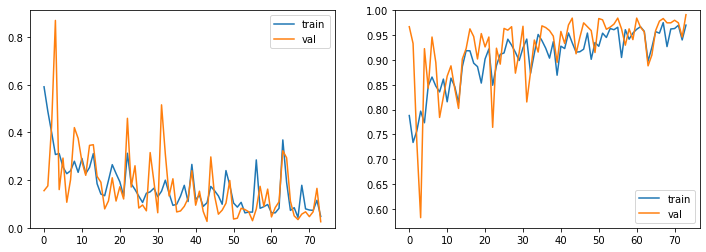

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5982 - accuracy: 0.5766 - precision: 0.9217 - recall: 0.5084 - f1: 0.6357 - specificity: 0.8048 - negative_predictive_value: 0.2929 - matthews_correlation_coefficient: 0.2706 - val_loss: 0.6044 - val_accuracy: 0.5169 - val_precision: 0.9620 - val_recall: 0.4207 - val_f1: 0.5728 - val_specificity: 0.9005 - val_negative_predictive_value: 0.2937 - val_matthews_correlation_coefficient: 0.2846

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28460, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_26-03_53_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5800 - accuracy: 0.5866 - precision: 0.9199 - recall: 0.5166 - f1: 0.6481 - specificity: 0.8145 - negative_predictive_value: 0.3141 - matthews_correlation_coefficient: 0.2816 - val_loss: 0.5551 - val_accuracy: 0.6522 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5237 - accuracy: 0.6692 - precision: 0.9395 - recall: 0.6231 - f1: 0.7405 - specificity: 0.8421 - negative_predictive_value: 0.3834 - matthews_correlation_coefficient: 0.3859 - val_loss: 0.5291 - val_accuracy: 0.6860 - val_precision: 0.9479 - val_recall: 0.6479 - val_f1: 0.7648 - val_specificity: 0.8326 - val_negative_predictive_value: 0.3859 - val_matthews_correlation_coefficient: 0.3991

Epoch 00015: val_matthews_correlation_coefficient improved from 0.38941 to 0.39905, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_26-03_53_06.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5162 - accuracy: 0.6835 - precision: 0.9471 - recall: 0.6365 - f1: 0.7543 - specificity: 0.8586 - negative_predictive_value: 0.3969 - matthews_correlation_coefficient: 0.4096 - val_loss: 0.5793 - val_accuracy: 0.6245 - val_precision: 0.9632 - val_recall: 0.5564 - val_f1: 0.6978 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4865 - accuracy: 0.7089 - precision: 0.9452 - recall: 0.6699 - f1: 0.7778 - specificity: 0.8478 - negative_predictive_value: 0.4205 - matthews_correlation_coefficient: 0.4330 - val_loss: 0.4884 - val_accuracy: 0.7251 - val_precision: 0.9354 - val_recall: 0.7108 - val_f1: 0.8038 - val_specificity: 0.7868 - val_negative_predictive_value: 0.4169 - val_matthews_correlation_coefficient: 0.4173

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41731
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4855 - accuracy: 0.7043 - precision: 0.9469 - recall: 0.6620 - f1: 0.7729 - specificity: 0.8560 - negative_predictive_value: 0.4122 - matthews_correlation_coefficient: 0.4297 - val_loss: 0.4380 - val_accuracy: 0.7606 - val_precision: 0.9250 - val_recall: 0.7671 - val_f1: 0.8354 - val_specificity: 0.7433 - val_negative_predictive_value: 0.4576 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4617 - accuracy: 0.7247 - precision: 0.9488 - recall: 0.6873 - f1: 0.7912 - specificity: 0.8597 - negative_predictive_value: 0.4313 - matthews_correlation_coefficient: 0.4534 - val_loss: 0.4334 - val_accuracy: 0.7667 - val_precision: 0.8989 - val_recall: 0.8017 - val_f1: 0.8452 - val_specificity: 0.6487 - val_negative_predictive_value: 0.4608 - val_matthews_correlation_coefficient: 0.4008

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.43999
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4658 - accuracy: 0.7260 - precision: 0.9393 - recall: 0.6882 - f1: 0.7875 - specificity: 0.8586 - negative_predictive_value: 0.4373 - matthews_correlation_coefficient: 0.4521 - val_loss: 0.4927 - val_accuracy: 0.7199 - val_precision: 0.9218 - val_recall: 0.6661 - val_f1: 0.7693 - val_specificity: 0.8338 - val_negative_predictive_value: 0.4195 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient improved from 0.44625 to 0.45971, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_26-03_53_06.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4330 - accuracy: 0.7399 - precision: 0.9481 - recall: 0.6972 - f1: 0.7996 - specificity: 0.8780 - negative_predictive_value: 0.4474 - matthews_correlation_coefficient: 0.4753 - val_loss: 0.5375 - val_accuracy: 0.7034 - val_precision: 0.9375 - val_recall: 0.6310 - val_f1: 0.7494 - val_specificity: 0.8795 - val_negative_predictive_value: 0.4078 - val_matthews_correlation_coefficient: 0.4454

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45971
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4385 - accuracy: 0.7447 - precision: 0.9537 - recall: 0.7086 - f1: 0.8084 - specificity: 0.8626 - negative_predictive_value: 0.4511 - matthews_correlation_coefficient: 0.4784 - val_loss: 0


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.45971
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4259 - accuracy: 0.7453 - precision: 0.9570 - recall: 0.7091 - f1: 0.8097 - specificity: 0.8742 - negative_predictive_value: 0.4538 - matthews_correlation_coefficient: 0.4874 - val_loss: 0.4409 - val_accuracy: 0.7285 - val_precision: 0.8842 - val_recall: 0.7079 - val_f1: 0.7835 - val_specificity: 0.7107 - val_negative_predictive_value: 0.4146 - val_matthews_correlation_coefficient: 0.3798

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45971
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4418 - accuracy: 0.7410 - precision: 0.9448 - recall: 0.7055 - f1: 0.8011 - specificity: 0.8594 - negative_predictive_value: 0.4539 - matthews_correlation_coefficient: 0.4769 - val_loss: 0.6030 - val_accuracy: 0.6236 - val_precision: 0.9364 - val_recall: 0.5298 - val_f1: 0.6713 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4181 - accuracy: 0.7460 - precision: 0.9547 - recall: 0.7146 - f1: 0.8136 - specificity: 0.8719 - negative_predictive_value: 0.4532 - matthews_correlation_coefficient: 0.4842 - val_loss: 0.5313 - val_accuracy: 0.6964 - val_precision: 0.9485 - val_recall: 0.6150 - val_f1: 0.7408 - val_specificity: 0.9054 - val_negative_predictive_value: 0.4042 - val_matthews_correlation_coefficient: 0.4542

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.47013
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4156 - accuracy: 0.7510 - precision: 0.9590 - recall: 0.7169 - f1: 0.8161 - specificity: 0.8835 - negative_predictive_value: 0.4562 - matthews_correlation_coefficient: 0.4952 - val_loss: 0.4076 - val_accuracy: 0.7728 - val_precision: 0.8854 - val_recall: 0.7671 - val_f1: 0.8198 - val_specificity: 0.6931 - val_negative_predictive_value: 0.4735 - val_matthews_correlation_coefficie

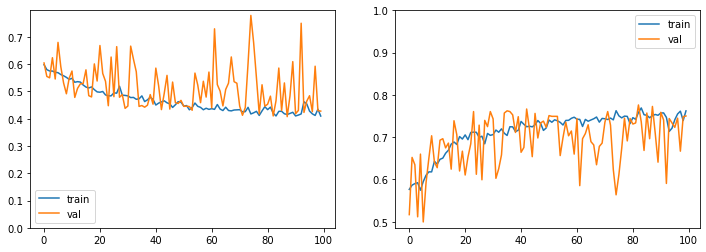

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5986 - accuracy: 0.5941 - precision: 0.9267 - recall: 0.5783 - f1: 0.6997 - specificity: 0.7120 - negative_predictive_value: 0.2285 - matthews_correlation_coefficient: 0.2093 - val_loss: 0.4820 - val_accuracy: 0.6886 - val_precision: 0.9229 - val_recall: 0.7005 - val_f1: 0.7928 - val_specificity: 0.6361 - val_negative_predictive_value: 0.2734 - val_matthews_correlation_coefficient: 0.2536

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25363, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_26-04_07_55.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5565 - accuracy: 0.6436 - precision: 0.9451 - recall: 0.6267 - f1: 0.7417 - specificity: 0.7535 - negative_predictive_value: 0.2713 - matthews_correlation_coefficient: 0.2856 - val_loss: 0.4888 - val_accuracy: 0.7199 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.39266
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5312 - accuracy: 0.6816 - precision: 0.9178 - recall: 0.6658 - f1: 0.7517 - specificity: 0.7574 - negative_predictive_value: 0.3076 - matthews_correlation_coefficient: 0.3217 - val_loss: 0.4960 - val_accuracy: 0.7233 - val_precision: 0.9479 - val_recall: 0.7222 - val_f1: 0.8160 - val_specificity: 0.7713 - val_negative_predictive_value: 0.3152 - val_matthews_correlation_coefficient: 0.3522

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.39266
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4742 - accuracy: 0.7130 - precision: 0.9482 - recall: 0.7025 - f1: 0.8000 - specificity: 0.7736 - negative_predictive_value: 0.3194 - matthews_correlation_coefficient: 0.3563 - val_loss: 0.5097 - val_accuracy: 0.6670 - val_precision: 0.9608 - val_recall: 0.6453 - val_f1: 0.7669 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4408 - accuracy: 0.7471 - precision: 0.9607 - recall: 0.7333 - f1: 0.8263 - specificity: 0.8092 - negative_predictive_value: 0.3505 - matthews_correlation_coefficient: 0.4044 - val_loss: 0.3957 - val_accuracy: 0.7840 - val_precision: 0.9464 - val_recall: 0.7979 - val_f1: 0.8636 - val_specificity: 0.7411 - val_negative_predictive_value: 0.3745 - val_matthews_correlation_coefficient: 0.4073

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.47791
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4408 - accuracy: 0.7536 - precision: 0.9623 - recall: 0.7444 - f1: 0.8348 - specificity: 0.8247 - negative_predictive_value: 0.3584 - matthews_correlation_coefficient: 0.4199 - val_loss: 0.4039 - val_accuracy: 0.7840 - val_precision: 0.9336 - val_recall: 0.8117 - val_f1: 0.8663 - val_specificity: 0.6649 - val_negative_predictive_value: 0.3617 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.49475
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3994 - accuracy: 0.7796 - precision: 0.9642 - recall: 0.7723 - f1: 0.8528 - specificity: 0.8316 - negative_predictive_value: 0.3882 - matthews_correlation_coefficient: 0.4537 - val_loss: 0.3238 - val_accuracy: 0.8369 - val_precision: 0.9394 - val_recall: 0.8711 - val_f1: 0.9023 - val_specificity: 0.6719 - val_negative_predictive_value: 0.4553 - val_matthews_correlation_coefficient: 0.4512

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49475
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3977 - accuracy: 0.7701 - precision: 0.9686 - recall: 0.7589 - f1: 0.8469 - specificity: 0.8335 - negative_predictive_value: 0.3779 - matthews_correlation_coefficient: 0.4464 - val_loss: 0.3138 - val_accuracy: 0.8621 - val_precision: 0.9100 - val_recall: 0.9346 - val_f1: 0.9211 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.49475
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4547 - accuracy: 0.7670 - precision: 0.9551 - recall: 0.7660 - f1: 0.8455 - specificity: 0.7614 - negative_predictive_value: 0.3679 - matthews_correlation_coefficient: 0.4049 - val_loss: 0.3692 - val_accuracy: 0.8413 - val_precision: 0.9449 - val_recall: 0.8693 - val_f1: 0.9039 - val_specificity: 0.7229 - val_negative_predictive_value: 0.4658 - val_matthews_correlation_coefficient: 0.4826

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.49475
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4236 - accuracy: 0.7798 - precision: 0.9601 - recall: 0.7784 - f1: 0.8539 - specificity: 0.8058 - negative_predictive_value: 0.3985 - matthews_correlation_coefficient: 0.4473 - val_loss: 0.4097 - val_accuracy: 0.7910 - val_precision: 0.9510 - val_recall: 0.8016 - val_f1: 0.8674 - val_spe

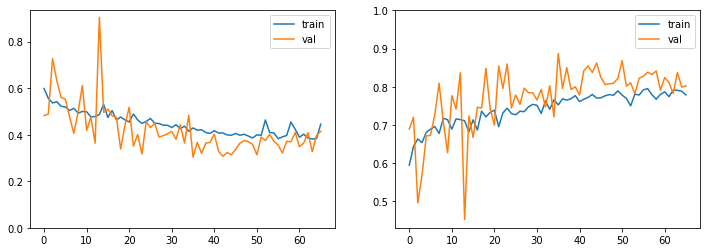

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_26-04_18_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_26-04_18_08.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_26-04_18_08.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1368 - accuracy: 0.9568 - precision: 0.9956 - recall: 0.9590 - f1: 0.9764 - specificity: 0.8237 - negative_predictive_value: 0.5995 - matthews_correlation_coefficient: 0.6681 - val_loss: 0.2811 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9002 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3000 - val_matthews_correlation_coefficient: 0.4515

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1291 - accuracy: 0.9584 - precision: 0.9964 - recall: 0.9594 - f1: 0.9769 - specificity: 0.8432 - negative_predictive_value: 0.6259 - matthews_correlation_coefficient: 0.6944 - val_loss: 0.1634 - val_accuracy: 0.9289 - val_precision: 0.9951 - val_recall: 0.9301 - val_f1: 0.9611 - val_specificity: 0.8144 - val_negative_predictive_value: 0.4317 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



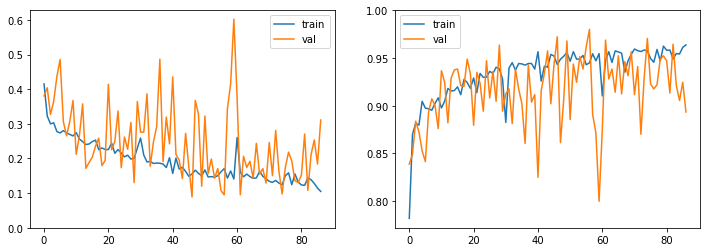

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6091 - accuracy: 0.6438 - precision: 0.8737 - recall: 0.6127 - f1: 0.6995 - specificity: 0.7352 - negative_predictive_value: 0.4170 - matthews_correlation_coefficient: 0.3160 - val_loss: 0.5523 - val_accuracy: 0.6704 - val_precision: 0.8375 - val_recall: 0.6443 - val_f1: 0.7243 - val_specificity: 0.6727 - val_negative_predictive_value: 0.4051 - val_matthews_correlation_coefficient: 0.3030

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30301, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_26-04_31_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5751 - accuracy: 0.6727 - precision: 0.8957 - recall: 0.6255 - f1: 0.7299 - specificity: 0.8018 - negative_predictive_value: 0.4345 - matthews_correlation_coefficient: 0.3804 - val_loss: 0.6445 - val_accuracy: 0.6201 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5415 - accuracy: 0.7091 - precision: 0.8965 - recall: 0.6882 - f1: 0.7715 - specificity: 0.7616 - negative_predictive_value: 0.4654 - matthews_correlation_coefficient: 0.4025 - val_loss: 0.5558 - val_accuracy: 0.7164 - val_precision: 0.8350 - val_recall: 0.7197 - val_f1: 0.7693 - val_specificity: 0.6291 - val_negative_predictive_value: 0.4581 - val_matthews_correlation_coefficient: 0.3454

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34848
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5420 - accuracy: 0.7061 - precision: 0.8891 - recall: 0.6818 - f1: 0.7661 - specificity: 0.7660 - negative_predictive_value: 0.4649 - matthews_correlation_coefficient: 0.3979 - val_loss: 0.6239 - val_accuracy: 0.6496 - val_precision: 0.8630 - val_recall: 0.5846 - val_f1: 0.6930 - val_specificity: 0.7860 - val_negative_predictive_value: 0.4227 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.35085
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5256 - accuracy: 0.7158 - precision: 0.9015 - recall: 0.6894 - f1: 0.7766 - specificity: 0.7766 - negative_predictive_value: 0.4696 - matthews_correlation_coefficient: 0.4158 - val_loss: 0.5764 - val_accuracy: 0.6774 - val_precision: 0.8659 - val_recall: 0.6247 - val_f1: 0.7204 - val_specificity: 0.7760 - val_negative_predictive_value: 0.4499 - val_matthews_correlation_coefficient: 0.3539

Epoch 00030: val_matthews_correlation_coefficient improved from 0.35085 to 0.35387, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_26-04_31_04.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5235 - accuracy: 0.7193 - precision: 0.9010 - recall: 0.6885 - f1: 0.7769 - specificity: 0.7870 - negative_predictive_value: 0.4728 - matthews_correlation_coefficient: 0.4198 - val_loss: 0.5732 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5153 - accuracy: 0.7150 - precision: 0.9097 - recall: 0.6853 - f1: 0.7754 - specificity: 0.8043 - negative_predictive_value: 0.4790 - matthews_correlation_coefficient: 0.4342 - val_loss: 0.6158 - val_accuracy: 0.6678 - val_precision: 0.8749 - val_recall: 0.6032 - val_f1: 0.7088 - val_specificity: 0.8071 - val_negative_predictive_value: 0.4457 - val_matthews_correlation_coefficient: 0.3609

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37028
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5101 - accuracy: 0.7217 - precision: 0.8987 - recall: 0.6922 - f1: 0.7774 - specificity: 0.7838 - negative_predictive_value: 0.4797 - matthews_correlation_coefficient: 0.4227 - val_loss: 0.6300 - val_accuracy: 0.6539 - val_precision: 0.8703 - val_recall: 0.5867 - val_f1: 0.6956 - val_specificity: 0.8026 - val_negative_predictive_value: 0.4317 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5050 - accuracy: 0.7252 - precision: 0.9094 - recall: 0.7011 - f1: 0.7870 - specificity: 0.8031 - negative_predictive_value: 0.4886 - matthews_correlation_coefficient: 0.4458 - val_loss: 0.5856 - val_accuracy: 0.6817 - val_precision: 0.8579 - val_recall: 0.6415 - val_f1: 0.7291 - val_specificity: 0.7210 - val_negative_predictive_value: 0.4259 - val_matthews_correlation_coefficient: 0.3464

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39621
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5080 - accuracy: 0.7176 - precision: 0.9082 - recall: 0.6878 - f1: 0.7763 - specificity: 0.7999 - negative_predictive_value: 0.4801 - matthews_correlation_coefficient: 0.4343 - val_loss: 0.5827 - val_accuracy: 0.6895 - val_precision: 0.8723 - val_recall: 0.6381 - val_f1: 0.7320 - val_specificity: 0.7914 - val_negative_predictive_value: 0.4654 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4927 - accuracy: 0.7351 - precision: 0.9112 - recall: 0.7125 - f1: 0.7940 - specificity: 0.7963 - negative_predictive_value: 0.4974 - matthews_correlation_coefficient: 0.4548 - val_loss: 0.5156 - val_accuracy: 0.7164 - val_precision: 0.8621 - val_recall: 0.6864 - val_f1: 0.7609 - val_specificity: 0.7486 - val_negative_predictive_value: 0.4847 - val_matthews_correlation_coefficient: 0.3867

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39621
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4993 - accuracy: 0.7312 - precision: 0.9026 - recall: 0.7053 - f1: 0.7855 - specificity: 0.8041 - negative_predictive_value: 0.4966 - matthews_correlation_coefficient: 0.4508 - val_loss: 0.6193 - val_accuracy: 0.6548 - val_precision: 0.8881 - val_recall: 0.5716 - val_f1: 0.6895 - val_specificity: 0.8462 - val_negative_predictive_value: 0.4387 - val_matthews_correlation_coefficie

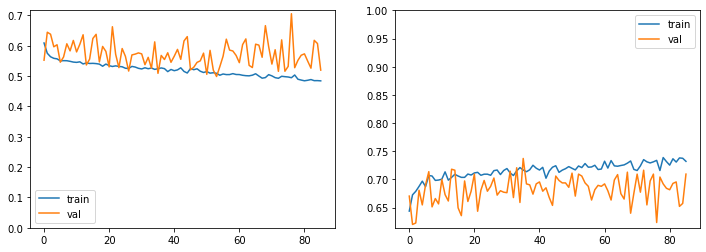

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5391 - accuracy: 0.7866 - precision: 0.9973 - recall: 0.7888 - f1: 0.8760 - specificity: 0.1448 - negative_predictive_value: 0.0220 - matthews_correlation_coefficient: 0.0447 - val_loss: 0.4205 - val_accuracy: 0.7892 - val_precision: 0.9730 - val_recall: 0.7670 - val_f1: 0.8564 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0323 - val_matthews_correlation_coefficient: 0.0680

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06797, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_26-04_43_52.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3327 - accuracy: 0.8228 - precision: 0.9991 - recall: 0.8235 - f1: 0.9008 - specificity: 0.1793 - negative_predictive_value: 0.0338 - matthews_correlation_coefficient: 0.0682 - val_loss: 0.2230 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2205 - accuracy: 0.8516 - precision: 1.0000 - recall: 0.8515 - f1: 0.9186 - specificity: 0.2207 - negative_predictive_value: 0.0476 - matthews_correlation_coefficient: 0.0938 - val_loss: 0.3402 - val_accuracy: 0.8630 - val_precision: 0.9730 - val_recall: 0.8394 - val_f1: 0.8999 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0577 - val_matthews_correlation_coefficient: 0.0904

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.09336
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2203 - accuracy: 0.8657 - precision: 0.9997 - recall: 0.8658 - f1: 0.9270 - specificity: 0.2207 - negative_predictive_value: 0.0479 - matthews_correlation_coefficient: 0.0936 - val_loss: 0.3639 - val_accuracy: 0.8673 - val_precision: 0.9730 - val_recall: 0.8436 - val_f1: 0.9023 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0581 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09624
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1926 - accuracy: 0.8779 - precision: 1.0000 - recall: 0.8778 - f1: 0.9340 - specificity: 0.2276 - negative_predictive_value: 0.0672 - matthews_correlation_coefficient: 0.1121 - val_loss: 0.2587 - val_accuracy: 0.8846 - val_precision: 0.9730 - val_recall: 0.8606 - val_f1: 0.9125 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0613 - val_matthews_correlation_coefficient: 0.0953

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09624
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2263 - accuracy: 0.8564 - precision: 0.9997 - recall: 0.8566 - f1: 0.9213 - specificity: 0.1966 - negative_predictive_value: 0.0481 - matthews_correlation_coefficient: 0.0891 - val_loss: 0.2129 - val_accuracy: 0.8864 - val_precision: 0.9730 - val_recall: 0.8624 - val_f1: 0.9136 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2137 - accuracy: 0.8742 - precision: 0.9998 - recall: 0.8743 - f1: 0.9315 - specificity: 0.2034 - negative_predictive_value: 0.0505 - matthews_correlation_coefficient: 0.0920 - val_loss: 0.2690 - val_accuracy: 0.8708 - val_precision: 0.9730 - val_recall: 0.8471 - val_f1: 0.9045 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0599 - val_matthews_correlation_coefficient: 0.0934

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.09624
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.8876 - precision: 1.0000 - recall: 0.8876 - f1: 0.9397 - specificity: 0.2345 - negative_predictive_value: 0.0628 - matthews_correlation_coefficient: 0.1123 - val_loss: 0.2497 - val_accuracy: 0.8890 - val_precision: 0.9730 - val_recall: 0.8649 - val_f1: 0.9149 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0620 - val_matthews_correlation_coefficie

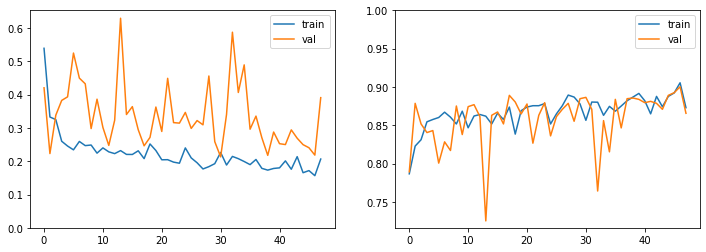

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_26-00_24_21.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_26-00_39_01.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_26-00_48_25.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_26-01_03_00.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_26-01_15_10.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_26-01_28_01.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_26-01_35_24.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_26-01_50_06.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_26-02_04_45.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_26-02_19_25.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_26-02_26_52.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_26-02_41_41.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_26-02_51_47.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.9999988]], dtype=float32),
 array([[0.6763466]], dtype=float32),
 array([[0.97955555]], dtype=float32),
 array([[0.98877907]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9631626]], dtype=float32),
 array([[0.93195415]], dtype=float32),
 array([[0.5520203]], dtype=float32),
 array([[0.53438604]], dtype=float32),
 array([[0.76629484]], dtype=float32),
 array([[0.958871]], dtype=float32),
 array([[0.7037488]], dtype=float32),
 array([[0.99992085]], dtype=float32),
 array([[0.99581736]], dtype=float32),
 array([[0.9751409]], dtype=float32),
 array([[0.39182523]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.93131554]], dtype=float32),
 array([[0.9999949]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.516194]], dtype=float32),
 array([[1.]], dtype=float32)]